# Functional Analysis Plots
### CAZyme, COG, and AMR visualizations


This notebook generates publication-ready plots from functional annotation feature tables (QIIME2 artifacts) and associated sample metadata.

It focuses on:
- CAZyme class composition and CAZy family-level patterns
- COG composition
- AMR total burden summaries


#### **Goal**

Create a consistent set of figures in `figures/` for downstream reporting:
- CAZyme class composition (stacked bars / clustering)
- CAZy family PCA and top-family dotplots
- COG composition plots
- AMR burden summaries


<div style="border:2px solid red; padding:10px; color:#b30000;">
<b>Note</b><br>
This notebook assumes the required QIIME2 `.qza` artifacts and the merged metadata table are already present under <code>data/07_Functional_analysis/</code>.
Several plotting steps depend on mapping functions (<code>id_to_sample</code>, <code>id_to_food</code>) created in <b>Step 1</b>, so run cells in order.
</div>


#### **Notebook Content:** ####
- [Prepare Environment](#prepare-environment)
- [Step 1. Build sample/food mapping](#step-1-build-samplefood-mapping)
- [Step 2. Export CAZ annotation feature table](#step-2-export-caz-annotation-feature-table)
- [Step 3. CAZyme class composition](#step-3-cazyme-class-composition)
- [Step 4. CAZy family PCA](#step-4-cazy-family-pca)
- [Step 5. Top CAZy families dot plot](#step-5-top-cazy-families-dot-plot)
- [Step 6. COG functional composition](#step-6-cog-functional-composition)
- [Step 7. AMR total burden by sample](#step-7-amr-total-burden-by-sample)
- [Step 8. AMR additional summaries](#step-8-amr-additional-summaries)


### **The workflow** ###


### Prepare Environment
#### Import packages and create local folders


In [1]:
#set up environment
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization

# create directories for the notebook. DO NOT change
data_dir = 'data/07_Functional_analysis'
!data_dir = 'data/07_Functional_analysis'

!mkdir -p data
!mkdir -p $data_dir

/usr/bin/sh: line 1: data_dir: command not found


#### Download input artifacts (if needed)


In [2]:
# fetches useful files for the current notebook. All files will be saved in $data_dir
!wget 'https://polybox.ethz.ch/index.php/s/WaSKZs2E5xn9SHm/download' -O data/Download.zip
!unzip -o data/Download.zip -d data
!rm data/Download.zip

--2025-12-14 19:14:25--  https://polybox.ethz.ch/index.php/s/WaSKZs2E5xn9SHm/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘data/Download.zip’

data/Download.zip       [            <=>     ] 310.65M   125MB/s    in 2.5s    

2025-12-14 19:14:28 (125 MB/s) - ‘data/Download.zip’ saved [325735603]

Archive:  data/Download.zip
 extracting: data/07_Functional_analysis/Euler_scripts/annotate_bacteria_95.sh  
 extracting: data/07_Functional_analysis/Euler_scripts/gunc_bacteria_95.sh  
 extracting: data/07_Functional_analysis/Euler_scripts/q2_gunc_db.sh  
 extracting: data/07_Functional_analysis/Euler_scripts/rgi_bacteria_95.sh  
 extracting: data/07_Functional_analysis/data/bacteria_95_gunc_results.qzv  
 extracting: data/07_Functional_analysis/data/caz_annot_ft_bacteria_95.qzv  
 extracting: 

### Step 1. Build sample/food mapping

This step builds robust ID mappers from the dereplication table so that downstream plots can be labeled consistently.
It creates helper functions such as `canon_id()`, `id_to_sample()`, and `id_to_food()` that are reused later.


In [3]:
from pathlib import Path
import subprocess, shutil
import pandas as pd
import numpy as np
import re

# =========================
# Build ID -> sample/food/category mappers from derep table
# Works for:
#   - member UUIDs (long uuid strings)
#   - rep IDs (e.g., pb_m010, il_ms003-2)
# =========================

# ---- paths ----
MAGS_TABLE_QZA = Path("data/07_Functional_analysis/data/mags_table_bacteria_95.qza")
META_TSV = Path("data/merged_metadata_filtered.tsv")   # must contain sample_ID + fermented_food_type (and optionally category)

EXPORT_DIR = Path("exported/mags_table_bacteria_95")
TSV = EXPORT_DIR / "feature-table.tsv"

# ---- regex ----
UUID_RE = re.compile(r"[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}", re.I)

def canon_id(s: str) -> str:
    """Extract UUID if present; otherwise lightly clean and lowercase."""
    s = str(s).strip()
    m = UUID_RE.search(s)
    if m:
        return m.group(0).lower()
    s = re.sub(r"^MAG[_\-]?", "", s, flags=re.I)
    return s.lower()

def read_biom_tsv(tsv_path: Path) -> pd.DataFrame:
    """Read biom-converted TSV (skip first comment line, keep header)."""
    df = pd.read_csv(tsv_path, sep="\t", skiprows=1)
    first_col = df.columns[0]
    df = df.set_index(first_col)
    return df.apply(pd.to_numeric, errors="coerce").fillna(0)



In [4]:
# ---- export qza -> biom -> tsv ----
if EXPORT_DIR.exists():
    shutil.rmtree(EXPORT_DIR)

subprocess.run(
    ["qiime", "tools", "export", "--input-path", str(MAGS_TABLE_QZA), "--output-path", str(EXPORT_DIR)],
    check=True
)
subprocess.run(
    ["biom", "convert", "-i", str(EXPORT_DIR / "feature-table.biom"), "-o", str(TSV), "--to-tsv"],
    check=True
)

tab = read_biom_tsv(TSV)

# ---- normalize row/col ids ----
tab.index = [canon_id(x) for x in tab.index]
tab.columns = [canon_id(x) for x in tab.columns]

# merge duplicates after normalization (no axis= warning)
tab = tab.groupby(level=0).sum()
tab = tab.T.groupby(level=0).sum().T

# ---- orient table: rows=members, cols=reps ----
row_sum = tab.sum(axis=1)
rows_are_members = (row_sum.replace(0, np.nan).median() <= 1.5)
if not rows_are_members:
    tab = tab.T

print("Interpreting mags_table as: rows=members, cols=reps. shape:", tab.shape)

# member -> rep
member_to_rep = tab.idxmax(axis=1).to_dict()
rep_ids = list(tab.columns)



/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported data/07_Functional_analysis/data/mags_table_bacteria_95.qza as BIOMV210DirFmt to directory exported/mags_table_bacteria_95
Interpreting mags_table as: rows=members, cols=reps. shape: (170, 45)


In [5]:
# ---- read metadata ----
meta = pd.read_csv(META_TSV, sep="\t", dtype=str)
if "sample_ID" not in meta.columns:
    raise ValueError(f"'sample_ID' column not found in {META_TSV}. Columns: {meta.columns.tolist()}")

meta["sample_ID"] = meta["sample_ID"].astype(str)

# required/optional metadata columns
FOOD_COL = "fermented_food_type"
CAT_COL  = "category"

sample2food = {}
if FOOD_COL in meta.columns:
    sample2food = meta.drop_duplicates("sample_ID").set_index("sample_ID")[FOOD_COL].to_dict()

sample2cat = {}
if CAT_COL in meta.columns:
    sample2cat = meta.drop_duplicates("sample_ID").set_index("sample_ID")[CAT_COL].to_dict()

# build robust parser: rep_id -> sample_ID using known sample IDs from metadata
sample_ids = meta["sample_ID"].dropna().astype(str).unique().tolist()
sid_lower_to_orig = {s.lower(): s for s in sample_ids}
sid_pattern = re.compile("|".join(sorted((re.escape(k) for k in sid_lower_to_orig.keys()), key=len, reverse=True))) if sample_ids else None

def rep_to_sample(rep_id: str) -> str | None:
    """
    Parse sample_ID from rep IDs like:
      pb_m010 -> M010
      il_ms003-2 -> MS003-2
      pb_a001 -> A001
    """
    r = str(rep_id).lower().strip()
    r = re.sub(r"^(il|pb)_", "", r)  # drop tech prefix
    if sid_pattern is None:
        return None
    m = sid_pattern.search(r)
    return sid_lower_to_orig[m.group(0)] if m else None

rep_to_sample_map = {rep: rep_to_sample(rep) for rep in rep_ids}



In [6]:
# ---- lookup functions ----
def id_to_sample(any_id: str) -> str:
    k = canon_id(any_id)
    rep = member_to_rep.get(k, k)   # member UUID -> rep; rep stays rep
    s = rep_to_sample_map.get(rep)
    return s if s else "NA"

def id_to_food(any_id: str) -> str:
    s = id_to_sample(any_id)
    return str(sample2food.get(s, "NA")) if s != "NA" else "NA"

def id_to_category(any_id: str) -> str:
    s = id_to_sample(any_id)
    return str(sample2cat.get(s, "NA")) if s != "NA" else "NA"



In [7]:
# ---- quick sanity check ----
test_ids = list(tab.index[:5]) + list(tab.columns[:5])
print("Sanity check:")
for t in test_ids:
    print(t, "->", id_to_sample(t), "|", id_to_food(t), "|", id_to_category(t))


Sanity check:
009d5f9a-be92-4328-b5ad-68d282a94e3b -> M010 | Fermented_fish_(Pla_Som)_from_grass_carp | fermented fish
0174159a-d8ba-4d10-995d-c9dddd2a0b48 -> M002 | Pickled_mussel_(Hoy_Dong)_from_Asian_green_mussel | fermented fish
01b54364-1bbb-43e7-9366-a931641ff6cd -> A001 | Fermented_pork_(Nham_Moo) | fermented meat
033e4bc6-2e06-4d36-a408-30aae536885c -> A001 | Fermented_pork_(Nham_Moo) | fermented meat
03727db6-e5bc-48a7-8dd0-01ef817cde25 -> A001 | Fermented_pork_(Nham_Moo) | fermented meat
il_a001 -> A001 | Fermented_pork_(Nham_Moo) | fermented meat
il_a002 -> A002 | Fermented_pork_sausage_(Sai-krok_Isaan_Moo) | fermented meat
il_b037_la_ac_la -> B037_La_Ac_La | Lanhouin | fermented fish
il_b038_az_gp_la -> B038_Az_Gp_La | Lanhouin | fermented fish
il_b039_aa_gp_la -> B039_Aa_Gp_La | Lanhouin | fermented fish


### Step 2. Export CAZ annotation feature table

Exports the CAZ annotation feature table from QIIME2 (`.qza`) to TSV and defines helper functions for parsing and sample ID extraction.


In [8]:
from pathlib import Path
import subprocess, shutil

TSV = Path("exported/caz_ft/feature-table.tsv")
EXPORT_DIR = Path("exported/caz_ft")
QZA = Path("data/07_Functional_analysis/data/caz_annot_ft_bacteria_95.qza")

if not TSV.exists():
    if EXPORT_DIR.exists():
        shutil.rmtree(EXPORT_DIR)

    subprocess.run([
        "qiime","tools","export",
        "--input-path", str(QZA),
        "--output-path", str(EXPORT_DIR)
    ], check=True)

    subprocess.run([
        "biom","convert",
        "-i", str(EXPORT_DIR/"feature-table.biom"),
        "-o", str(TSV),
        "--to-tsv"
    ], check=True)

print("Using TSV:", TSV)

Using TSV: exported/caz_ft/feature-table.tsv


### Step 3. CAZyme class composition

**Figure: stacked bar chart of CAZyme class composition (Top N samples).**

- **What it is:** Each bar is one sample (labels come from the ID→sample/food mappers in Step 1). The colored segments are CAZy *classes* (e.g., **GH**, **GT**, **CE**, **PL**, **AA**, **CBM**).
- **What it shows:** How the functional *class-level* CAZyme profile differs between samples. If you plot **proportions**, bars sum to 1; if you plot **counts**, taller bars indicate higher total CAZyme signal.
- **How to read it:** Look for (i) samples dominated by a single class, (ii) class shifts between foods/categories, and (iii) unusually high/low totals (the number above each bar, if enabled).


In [9]:
# =========================
# CAZyme class composition (label by sample/food via mags_table mapping)
# Requires existing in notebook (from the successful mapping cell):
#   - id_to_sample(any_id)
#   - id_to_food(any_id)
#   - canon_id(any_id)   (if not, we re-define a compatible one below)
# =========================

from pathlib import Path
import subprocess, shutil
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

%matplotlib inline

# ---------- sanity: mapping functions must exist ----------
if "id_to_sample" not in globals() or "id_to_food" not in globals():
    raise RuntimeError("Please run the mags_table -> id_to_sample/id_to_food mapping cell first (Sanity check must pass).")

# ---------- config ----------
QZA = Path("data/07_Functional_analysis/data/caz_annot_ft_bacteria_95.qza")
EXPORT_DIR = Path("exported/caz_ft")
TSV = EXPORT_DIR / "feature-table.tsv"
OUT_DIR = Path("figures")
OUT_DIR.mkdir(parents=True, exist_ok=True)

N = 20
DO_EXPORT = False  # Set False if TSV already exists (from qiime export / biom convert); set True to re-export automatically

# eukaryota MAG UUIDs to exclude (raw UUIDs)
EXCLUDE_UUIDS = {
    "09ebb84d-e6d1-4c36-871b-45bee0ad115d",
    "0c0b33fc-4ed2-4d06-b60c-4a5855e0e58b",
}



In [10]:
# ---------- helpers ----------
UUID_RE = re.compile(r"[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}", re.I)

# If canon_id is already defined in the mapping cell, reuse it; otherwise define a compatible version
if "canon_id" not in globals():
    def canon_id(s: str) -> str:
        s = str(s).strip()
        m = UUID_RE.search(s)
        if m:
            return m.group(0).lower()
        s = re.sub(r"^MAG[_\-]?", "", s, flags=re.I)
        return s.lower()

def cazy_class(feature_id: str) -> str:
    m = re.match(r"^(GH|GT|CE|PL|AA|CBM)\d+", str(feature_id).strip(), flags=re.I)
    return m.group(1).upper() if m else "Other"

def read_biom_tsv(tsv_path: Path) -> pd.DataFrame:
    # biom convert output: row 1 is a comment, row 2 is the header
    df = pd.read_csv(tsv_path, sep="\t", skiprows=1)
    first_col = df.columns[0]  # '#OTU ID' or similar
    return df.set_index(first_col)

def stacked_bar(plot_df, title, ylabel, totals=None, out_prefix="plot", is_prop=False):
    order = [c for c in ["GH","GT","CE","PL","AA","CBM","Other"] if c in plot_df.columns]
    x = np.arange(plot_df.shape[0])

    fig, ax = plt.subplots(figsize=(22, 8))
    bottom = np.zeros(plot_df.shape[0])

    for cls in order:
        vals = plot_df[cls].values
        ax.bar(x, vals, bottom=bottom, label=cls)
        bottom += vals

    # totals annotation
    if totals is not None:
        if is_prop:
            y_text = 1.03
            for i, lab in enumerate(plot_df.index):
                ax.text(i, y_text, f"{int(totals.loc[lab])}",
                        ha="center", va="bottom", fontsize=8, rotation=0)
        else:
            ypad = 0.01 * (bottom.max() if bottom.max() > 0 else 1)
            for i, lab in enumerate(plot_df.index):
                ax.text(i, bottom[i] + ypad, f"{int(totals.loc[lab])}",
                        ha="center", va="bottom", fontsize=8, rotation=0)

    ax.set_xticks(x)
    ax.set_xticklabels(plot_df.index, rotation=60, ha="right", fontsize=7)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(ncols=7, bbox_to_anchor=(0.5, 1.22), loc="upper center")

    if is_prop:
        ax.set_ylim(0, 1.18)
    fig.subplots_adjust(bottom=0.40, top=0.78)

    pdf = OUT_DIR / f"{out_prefix}.pdf"
    svg = OUT_DIR / f"{out_prefix}.svg"
    fig.savefig(pdf, dpi=300)
    fig.savefig(svg)
    plt.show()
    print("Saved:", pdf)
    print("Saved:", svg)

def make_label(sample_id: str) -> str:
    """
    sample_id may be:
      - member UUID
      - rep id (pb_m010 / il_ms003-2 ...)
    We consistently map via id_to_sample / id_to_food
    """
    sid = str(sample_id)
    short = canon_id(sid)
    # If it is a UUID, use the first 8 chars; otherwise keep the original string (more readable)
    if UUID_RE.search(sid):
        short = short[:8]
    else:
        short = sid
    return f"{id_to_sample(sid)} | {id_to_food(sid)} | {short}"



In [11]:
# ---------- export qza -> biom -> tsv (optional) ----------
if DO_EXPORT:
    if EXPORT_DIR.exists():
        shutil.rmtree(EXPORT_DIR)
    subprocess.run([
        "qiime", "tools", "export",
        "--input-path", str(QZA),
        "--output-path", str(EXPORT_DIR)
    ], check=True)

    subprocess.run([
        "biom", "convert",
        "-i", str(EXPORT_DIR / "feature-table.biom"),
        "-o", str(TSV),
        "--to-tsv"
    ], check=True)

# ---------- read matrix (features x sampleIDs) ----------
df = read_biom_tsv(TSV)
mat = df.apply(pd.to_numeric, errors="coerce").fillna(0)

# Normalize column names (more robust for dropping/merging)
mat.columns = [canon_id(c) if UUID_RE.search(str(c)) else str(c).strip() for c in mat.columns]
# Merge any duplicate columns (avoid axis= to prevent pandas FutureWarning)
mat = mat.T.groupby(level=0).sum().T

# ---------- exclude eukaryota IDs ----------
exclude_keys = {canon_id(u) for u in EXCLUDE_UUIDS}
# Optional: if member_to_rep exists (from the mapping cell), also drop the corresponding rep IDs for safety
rep_exclude = set()
if "member_to_rep" in globals():
    for u in EXCLUDE_UUIDS:
        k = canon_id(u)
        if k in member_to_rep:
            rep_exclude.add(member_to_rep[k])

cols_before = set(mat.columns)
mat = mat.drop(columns=[c for c in mat.columns if (c in exclude_keys) or (c in rep_exclude)], errors="ignore")
print("Excluded:", sorted((cols_before - set(mat.columns))))

print("Matrix shape (features x sampleIDs):", mat.shape)
print("Example columns:", list(mat.columns[:5]))



Excluded: ['09ebb84d-e6d1-4c36-871b-45bee0ad115d']
Matrix shape (features x sampleIDs): (102, 169)
Example columns: ['009d5f9a-be92-4328-b5ad-68d282a94e3b', '0174159a-d8ba-4d10-995d-c9dddd2a0b48', '01b54364-1bbb-43e7-9366-a931641ff6cd', '033e4bc6-2e06-4d36-a408-30aae536885c', '03727db6-e5bc-48a7-8dd0-01ef817cde25']


In [12]:
# ---------- sum into CAZyme classes ----------
classes = pd.Series(mat.index, index=mat.index).map(cazy_class)
class_sum = mat.groupby(classes).sum()  # class x sampleID

# keep standard order
order = [c for c in ["GH","GT","CE","PL","AA","CBM","Other"] if c in class_sum.index]
class_sum = class_sum.loc[order]

totals_all = class_sum.sum(axis=0)

# ---------- top N ----------
top_ids = totals_all.sort_values(ascending=False).head(N).index
top_totals_raw = totals_all.loc[top_ids]

top_counts = class_sum[top_ids].T  # sampleID x class
top_prop = (class_sum[top_ids] / top_totals_raw.replace(0, np.nan)).T.fillna(0)

# ---------- relabel for plotting ----------
labels = [make_label(x) for x in top_ids]

top_counts.index = labels
top_prop.index = labels

top_totals = top_totals_raw.copy()
top_totals.index = labels



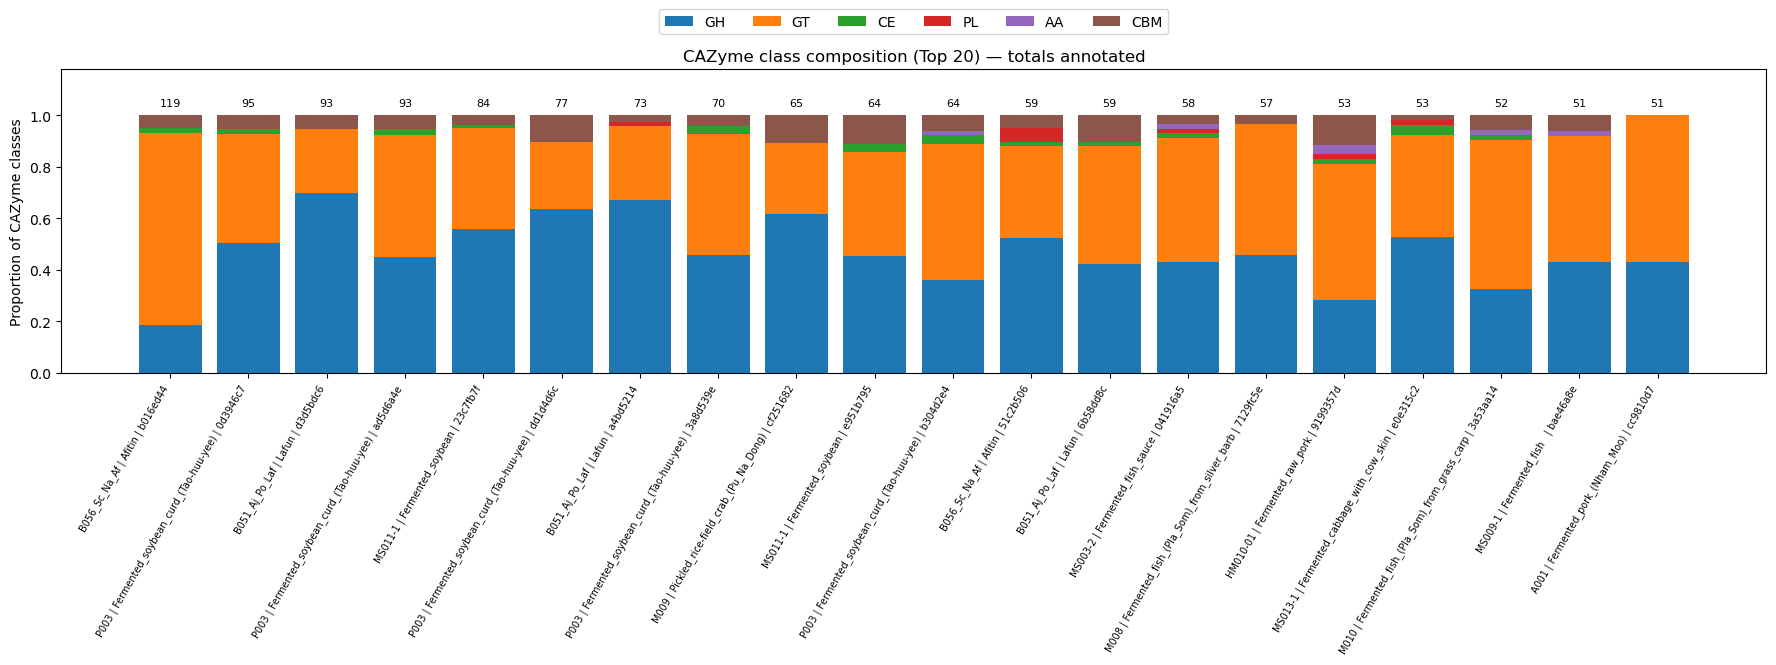

Saved: figures/cazy_class_top20_prop_annot_labeled.pdf
Saved: figures/cazy_class_top20_prop_annot_labeled.svg


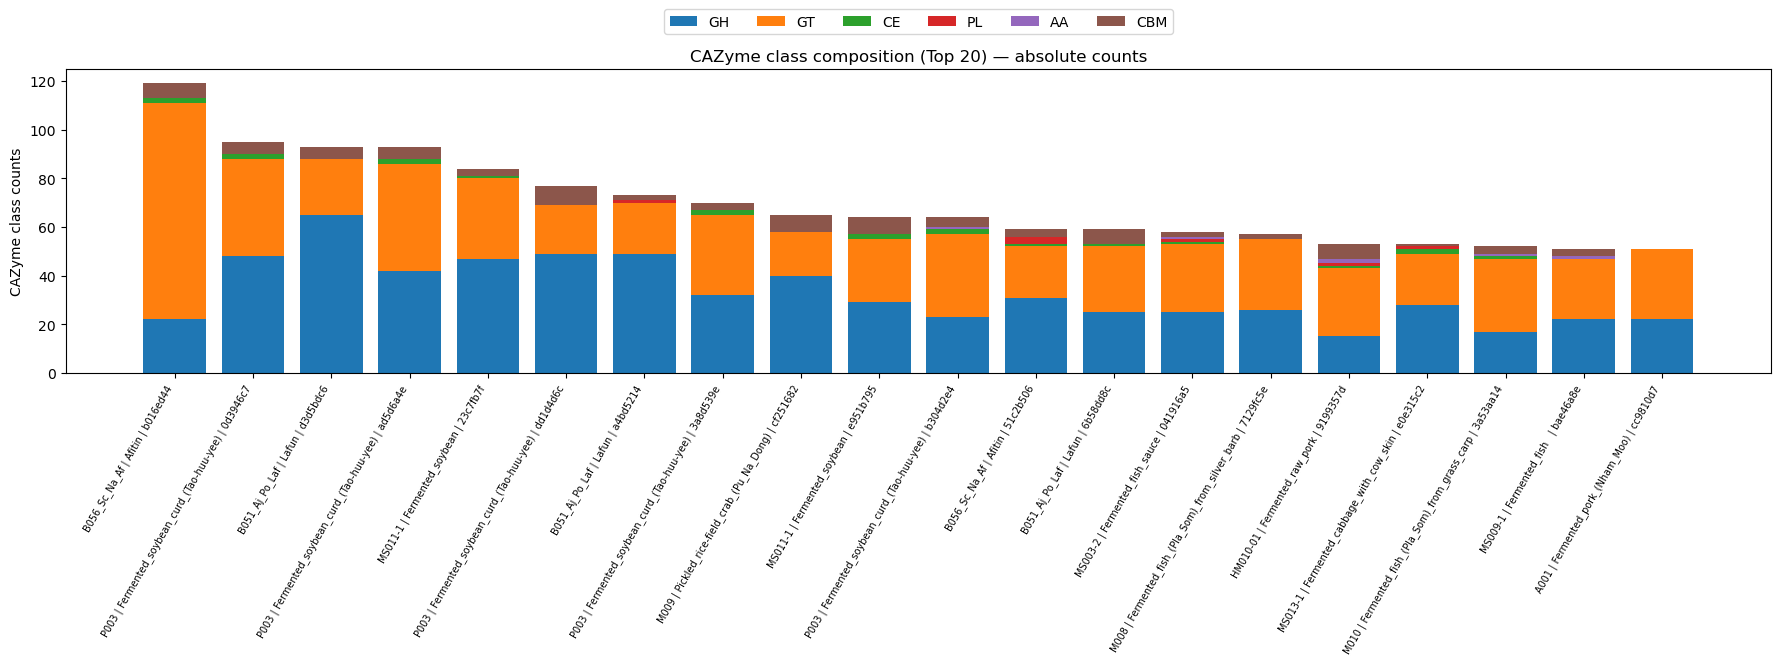

Saved: figures/cazy_class_top20_counts_labeled.pdf
Saved: figures/cazy_class_top20_counts_labeled.svg


,id,sample_ID,food,cazy_total
0,b016ed44-d4d7-4927-b6fc-b8eb341adbf7,B056_Sc_Na_Af,Afitin,119.0
1,0d3946c7-472e-4e65-9a78-4bd5da7a798a,P003,Fermented_soybean_curd_(Tao-huu-yee),95.0
2,d3d5bdc6-92ad-418e-9ee7-efe0eac936dd,B051_Aj_Po_Laf,Lafun,93.0
3,ad5d6a4e-4c40-4985-96c1-5d4a92079153,P003,Fermented_soybean_curd_(Tao-huu-yee),93.0
4,23c7fb7f-7a16-4a02-8fc8-e5e9741cfd34,MS011-1,Fermented_soybean,84.0
5,dd1d4d6c-3885-4d2f-aaed-0701d6b5e3dd,P003,Fermented_soybean_curd_(Tao-huu-yee),77.0
6,a4bd5214-4abd-414f-b281-c044b6fc0f44,B051_Aj_Po_Laf,Lafun,73.0
7,3a8d539e-926e-480b-8867-10c7740f1798,P003,Fermented_soybean_curd_(Tao-huu-yee),70.0
8,cf251682-eb31-4678-b895-4175748b5b80,M009,Pickled_rice-field_crab_(Pu_Na_Dong),65.0
10,b304d2e4-3e55-47a1-87e1-f2582bedd2a5,P003,Fermented_soybean_curd_(Tao-huu-yee),64.0


In [13]:
# ---------- plot ----------
stacked_bar(
    plot_df=top_prop,
    title=f"CAZyme class composition (Top {N}) — totals annotated",
    ylabel="Proportion of CAZyme classes",
    totals=top_totals,
    out_prefix=f"cazy_class_top{N}_prop_annot_labeled",
    is_prop=True
)

stacked_bar(
    plot_df=top_counts,
    title=f"CAZyme class composition (Top {N}) — absolute counts",
    ylabel="CAZyme class counts",
    totals=None,
    out_prefix=f"cazy_class_top{N}_counts_labeled",
    is_prop=False
)

# ---------- top list table ----------
top_list = pd.DataFrame({
    "id": list(top_ids),
    "sample_ID": [id_to_sample(x) for x in top_ids],
    "food": [id_to_food(x) for x in top_ids],
    "cazy_total": top_totals_raw.values
}).sort_values("cazy_total", ascending=False)

display(top_list)


### Step 4. CAZy family PCA

**Figures: PCA scatter plots of CAZy *family*-level profiles (Top-N and/or All families).**

- **What it is:** A dimensionality reduction of the per-sample CAZy family abundance matrix. Each point is a sample; points are colored by food (or other grouping).
- **What it shows:** Samples that cluster together have **similar CAZy family repertoires** after normalization (log1p + z-score per feature).
- **How to read it:** Check whether samples separate by food/category along PC1/PC2 (the axis labels include explained variance). If a zoom/outlier report is enabled, you can identify samples driving separation.


In [14]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# =========================
# CAZy family PCA (TopN + All)
# - excludes known euk IDs
# - labels/colored by food via id_to_food()
# - outputs:
#     figures/cazy_pca_topN_labeled.png
#     figures/cazy_pca_all_full.png
#     figures/cazy_pca_all_zoom.png
#     figures/cazy_pca_all_outliers.tsv
# =========================

# ---- require mapping fns exist ----
if "id_to_sample" not in globals() or "id_to_food" not in globals():
    raise RuntimeError("Please run the mags_table mapping cell first (id_to_sample/id_to_food).")

OUT_DIR = Path("figures")
OUT_DIR.mkdir(exist_ok=True, parents=True)

UUID_RE = re.compile(r"[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}", re.I)

# If canon_id already exists (from mapping cell), keep it; otherwise define one.
if "canon_id" not in globals():
    def canon_id(s: str) -> str:
        s = str(s).strip()
        m = UUID_RE.search(s)
        if m:
            return m.group(0).lower()
        s = re.sub(r"^MAG[_\-]?", "", s, flags=re.I)
        return s.lower()



In [15]:
# ---- eukaryota UUIDs to exclude ----
EXCLUDE_UUIDS = {
    "09ebb84d-e6d1-4c36-871b-45bee0ad115d",
    "0c0b33fc-4ed2-4d06-b60c-4a5855e0e58b",
}
EXCLUDE_KEYS = {canon_id(x) for x in EXCLUDE_UUIDS}

def drop_excluded_columns(mat_fxS: pd.DataFrame) -> pd.DataFrame:
    """Drop excluded UUID cols; if member_to_rep exists, drop corresponding reps too."""
    cols = list(mat_fxS.columns)

    # drop direct UUID columns
    to_drop = set(c for c in cols if c in EXCLUDE_KEYS)

    # if member_to_rep exists, also drop their reps (extra safety)
    if "member_to_rep" in globals():
        for u in EXCLUDE_KEYS:
            rep = member_to_rep.get(u)
            if rep is not None and rep in cols:
                to_drop.add(rep)

    if to_drop:
        print("Excluding columns:", sorted(to_drop))
        return mat_fxS.drop(columns=list(to_drop), errors="ignore")
    return mat_fxS



In [16]:
def pca_2d(X: np.ndarray):
    """Simple PCA via SVD. Returns (scores2d, explained_variance_ratio[2])."""
    Xc = X - X.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    scores = U[:, :2] * S[:2]
    var = (S**2) / (X.shape[0] - 1)
    evr = var / var.sum()
    return scores, evr[:2]

def make_pca_plot(mat_features_x_samples: pd.DataFrame,
                  title: str,
                  outpath: Path,
                  color_by: str = "food",
                  show_legend_max_groups: int = 15,
                  zoom_quantile: tuple[float, float] | None = None,
                  outlier_report_path: Path | None = None):
    """
    mat_features_x_samples: features x samples (counts)

    zoom_quantile:
      None -> full view
      (0.01, 0.99) -> zoom to 1%~99% quantiles for both axes

    outlier_report_path:
      if provided and zoom_quantile is not None, writes a TSV listing outliers.
    """
    # samples x features
    X = mat_features_x_samples.T.copy()

    # log reduce skew
    X = np.log1p(X)

    # z-score per feature
    X = (X - X.mean(axis=0)) / X.std(axis=0).replace(0, 1)

    scores, evr2 = pca_2d(X.values)
    pc1, pc2 = scores[:, 0], scores[:, 1]

    # group labels
    if color_by == "food":
        groups = pd.Series([id_to_food(s) for s in X.index], index=X.index)
        group_name = "Food"
    elif color_by == "sample":
        groups = pd.Series([id_to_sample(s) for s in X.index], index=X.index)
        group_name = "Sample"
    else:
        groups = pd.Series(["All"] * len(X.index), index=X.index)
        group_name = "Group"

    # zoom limits + outliers
    outlier_mask = np.zeros(len(X.index), dtype=bool)
    xlim = ylim = None
    if zoom_quantile is not None:
        lo, hi = zoom_quantile
        x1, x2 = np.quantile(pc1, [lo, hi])
        y1, y2 = np.quantile(pc2, [lo, hi])
        xpad = 0.05 * (x2 - x1 if x2 > x1 else 1)
        ypad = 0.05 * (y2 - y1 if y2 > y1 else 1)
        xlim = (x1 - xpad, x2 + xpad)
        ylim = (y1 - ypad, y2 + ypad)
        outlier_mask = (pc1 < xlim[0]) | (pc1 > xlim[1]) | (pc2 < ylim[0]) | (pc2 > ylim[1])

        if outlier_report_path is not None:
            out_df = pd.DataFrame({
                "id": list(X.index),
                "sample_ID": [id_to_sample(i) for i in X.index],
                "food": [id_to_food(i) for i in X.index],
                "PC1": pc1,
                "PC2": pc2,
                "is_outlier": outlier_mask
            }).sort_values(["is_outlier", "PC1"], ascending=[False, True])
            out_df.to_csv(outlier_report_path, sep="\t", index=False)
            print("Saved outlier report:", outlier_report_path)
            print("Outliers (head):")
            display(out_df[out_df["is_outlier"]].head(10))

    # Plot PCA scores (PC1 vs PC2), colored by the selected grouping variable
    plt.figure(figsize=(8, 6))

    uniq = groups.unique().tolist()
    show_legend = len(uniq) <= show_legend_max_groups

    for g in uniq:
        mask = (groups == g).values
        plt.scatter(pc1[mask], pc2[mask], alpha=0.75, s=25, label=g if show_legend else None)

    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel(f"PC1 ({evr2[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({evr2[1]*100:.1f}%)")
    plt.title(title)

    if show_legend:
        plt.legend(title=group_name, bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)

    plt.tight_layout()
    plt.savefig(outpath, dpi=300)
    plt.show()
    print("Saved:", outpath)



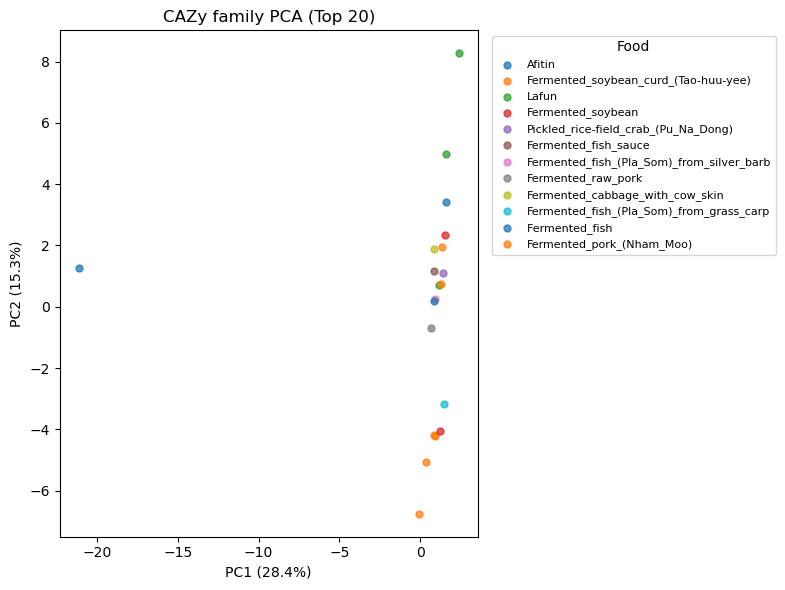

Saved: figures/cazy_pca_topN_labeled.png


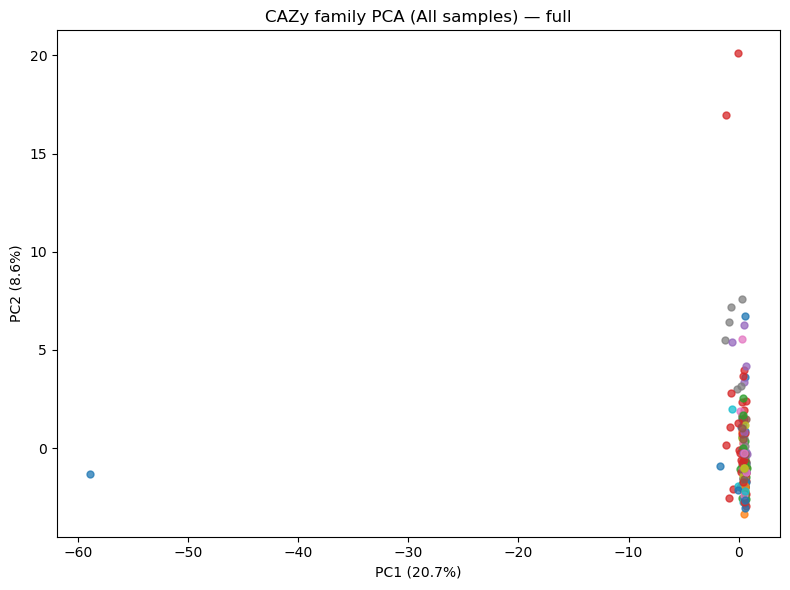

Saved: figures/cazy_pca_all_full.png
Saved outlier report: figures/cazy_pca_all_outliers.tsv
Outliers (head):


,id,sample_ID,food,PC1,PC2,is_outlier
118,b016ed44-d4d7-4927-b6fc-b8eb341adbf7,B056_Sc_Na_Af,Afitin,-58.903633,-1.339559,True
58,46e63349-c8f6-49f0-9f0f-5ac18f8750ea,B056_Sc_Na_Af,Afitin,-1.675409,-0.926803,True
112,a4bd5214-4abd-414f-b281-c044b6fc0f44,B051_Aj_Po_Laf,Lafun,-1.125599,16.956889,True
144,d3d5bdc6-92ad-418e-9ee7-efe0eac936dd,B051_Aj_Po_Laf,Lafun,-0.068114,20.101310,True


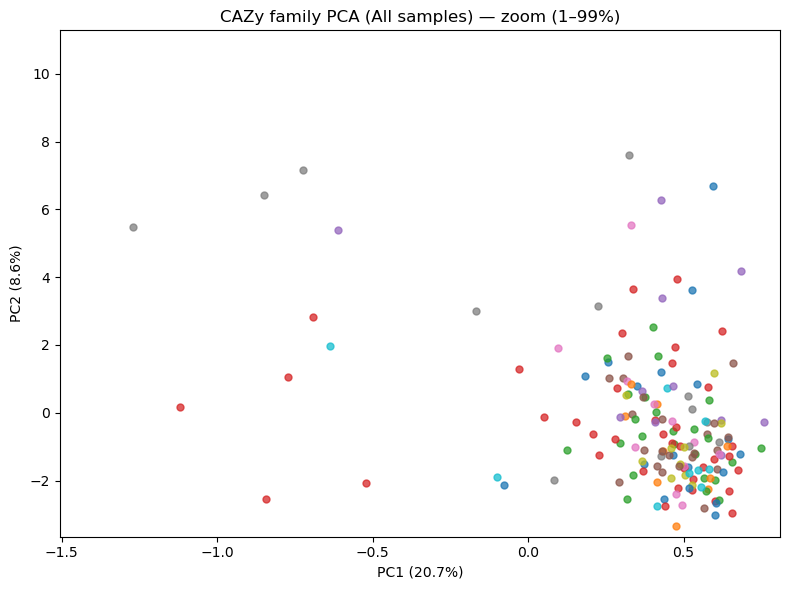

Saved: figures/cazy_pca_all_zoom.png


In [17]:
# =========================
# Prepare matrix for PCA
# =========================

# Ensure column IDs consistent + merge duplicates
mat_pca = mat.copy()
mat_pca.columns = [canon_id(c) if UUID_RE.search(str(c)) else str(c).strip() for c in mat_pca.columns]
mat_pca = mat_pca.T.groupby(level=0).sum().T

# Exclude euks
mat_pca = drop_excluded_columns(mat_pca)

# TopN selection by total counts across CAZy families
N = 20
totals = mat_pca.sum(axis=0)
top_ids = totals.sort_values(ascending=False).head(N).index

# =========================
# Plots
# =========================

# 1) TopN PCA
make_pca_plot(
    mat_pca[top_ids],
    title=f"CAZy family PCA (Top {len(top_ids)})",
    outpath=OUT_DIR / "cazy_pca_topN_labeled.png",
    color_by="food"
)

# 2) All samples PCA (full view)
make_pca_plot(
    mat_pca,
    title="CAZy family PCA (All samples) — full",
    outpath=OUT_DIR / "cazy_pca_all_full.png",
    color_by="food",
    zoom_quantile=None
)

# 3) All samples PCA (zoom view) + outlier report
make_pca_plot(
    mat_pca,
    title="CAZy family PCA (All samples) — zoom (1–99%)",
    outpath=OUT_DIR / "cazy_pca_all_zoom.png",
    color_by="food",
    zoom_quantile=(0.01, 0.99),
    outlier_report_path=OUT_DIR / "cazy_pca_all_outliers.tsv"
)


### Step 5. Top CAZy families dot plot

**Figure: bubble (dot) plot of Top CAZy families across selected samples.**

- **What it is:** A matrix-style visualization where **x = CAZy family**, **y = sample**. Each dot represents the abundance of a family in a sample.
- **Encoding:**  
  - **Dot size** scales with relative abundance (after a log transform + quantile scaling).  
  - **Dot color** encodes the CAZy class (GH/GT/CE/PL/AA/CBM/Other), so you can see class structure at a glance.
- **What it shows:** Which families are broadly shared versus sample-specific, and which foods/samples are enriched for particular family groups.


In [18]:
from pathlib import Path
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ---------------------------
# REQUIRE: mapping functions exist
# ---------------------------
if "id_to_sample" not in globals() or "id_to_food" not in globals():
    raise RuntimeError("Please run the mags_table mapping cell first (id_to_sample/id_to_food).")

# ---------------------------
# Params (edit as needed)
# ---------------------------
N_SAMPLES = 25   # Top samples/IDs
N_FAMS = 30      # Top CAZy families
OUT = Path("figures/cazy_topfamilies_dotplot_rel_discrete_labeled.png")
OUT.parent.mkdir(parents=True, exist_ok=True)

# eukaryota IDs to exclude
EXCLUDE_UUIDS = {
    "09ebb84d-e6d1-4c36-871b-45bee0ad115d",
    "0c0b33fc-4ed2-4d06-b60c-4a5855e0e58b",
}

UUID_RE = re.compile(r"[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}", re.I)

# use existing canon_id if present; otherwise define compatible one
if "canon_id" not in globals():
    def canon_id(s: str) -> str:
        s = str(s).strip()
        m = UUID_RE.search(s)
        if m:
            return m.group(0).lower()
        s = re.sub(r"^MAG[_\-]?", "", s, flags=re.I)
        return s.lower()

EXCLUDE_KEYS = {canon_id(x) for x in EXCLUDE_UUIDS}

def drop_excluded_columns(mat_fxS: pd.DataFrame) -> pd.DataFrame:
    """Drop excluded UUID cols; if member_to_rep exists, also drop corresponding reps."""
    cols = list(mat_fxS.columns)
    to_drop = set(c for c in cols if c in EXCLUDE_KEYS)

    if "member_to_rep" in globals():
        for u in EXCLUDE_KEYS:
            rep = member_to_rep.get(u)
            if rep is not None and rep in cols:
                to_drop.add(rep)

    if to_drop:
        print("Excluding columns:", sorted(to_drop))
        return mat_fxS.drop(columns=list(to_drop), errors="ignore")
    return mat_fxS

def cazy_class(fam: str) -> str:
    m = re.match(r"^(GH|GT|CE|PL|AA|CBM)\d+", str(fam).strip(), flags=re.I)
    return m.group(1).upper() if m else "Other"

def make_id_label(x: str, short_uuid: bool = True) -> str:
    """
    Y-axis label: sample_ID | food | short-id
    - If a UUID: use the first 8 characters as short-id
    - If not a UUID: use the original id as short-id (e.g., pb_m010)
    """
    x = str(x)
    samp = id_to_sample(x)
    food = id_to_food(x)
    if short_uuid and UUID_RE.search(x):
        sid = canon_id(x)[:8]
    else:
        sid = x
    return f"{samp} | {food} | {sid}"



In [19]:
# ---------------------------
# prepare matrix: normalize columns + merge duplicates + drop euks
# ---------------------------
mat2 = mat.copy()

# Normalize column names (UUID -> canonical; non-UUID -> strip/lower via canon_id)
mat2.columns = [canon_id(c) if UUID_RE.search(str(c)) else canon_id(str(c)) for c in mat2.columns]

# Merge duplicate columns (avoid axis= FutureWarning)
mat2 = mat2.T.groupby(level=0).sum().T

# Exclude eukaryote IDs
mat2 = drop_excluded_columns(mat2)

# ---------------------------
# choose top samples/families
# ---------------------------
sample_totals = mat2.sum(axis=0).sort_values(ascending=False)
top_samples = sample_totals.head(N_SAMPLES).index

fam_totals = mat2[top_samples].sum(axis=1).sort_values(ascending=False)
top_fams = fam_totals.head(N_FAMS).index

sub = mat2.loc[top_fams, top_samples]  # fam x sample (counts)

# ---------------------------
# convert to relative abundance within each sample
# ---------------------------
sub_rel = sub.div(sub.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)  # fam x sample

# long table: family, id, rel
long = sub_rel.stack().reset_index(name="rel")
long.columns = ["family", "id", "rel"]
long = long[long["rel"] > 0].copy()



In [20]:
# ---------------------------
# size and color (discrete by class)
# ---------------------------
long["class"] = long["family"].map(cazy_class)

# dot size: log10(CPM+1) then quantile-scale
long["size_raw"] = np.log10(long["rel"] * 1e6 + 1)

v = long["size_raw"].values
v_lo, v_hi = np.quantile(v, [0.01, 0.99])
v_scaled = (v - v_lo) / (v_hi - v_lo + 1e-12)
v_scaled = np.clip(v_scaled, 0, 1)
s_min, s_max = 15, 250
long["size"] = s_min + v_scaled * (s_max - s_min)

# axis order
id_order = list(top_samples)     # y: sample IDs (top totals)
fam_order = list(top_fams)       # x: top families
id_to_y = {u:i for i,u in enumerate(id_order)}
fam_to_x = {f:i for i,f in enumerate(fam_order)}
long["x"] = long["family"].map(fam_to_x)
long["y"] = long["id"].map(id_to_y)

# fixed class colors (tab10)
tab10 = plt.get_cmap("tab10")
class_colors = {
    "GH": tab10(0),
    "GT": tab10(1),
    "CE": tab10(2),
    "PL": tab10(3),
    "AA": tab10(4),
    "CBM": tab10(5),
    "Other": tab10(7),
}
point_colors = long["class"].apply(lambda x: class_colors.get(x, class_colors["Other"])).tolist()



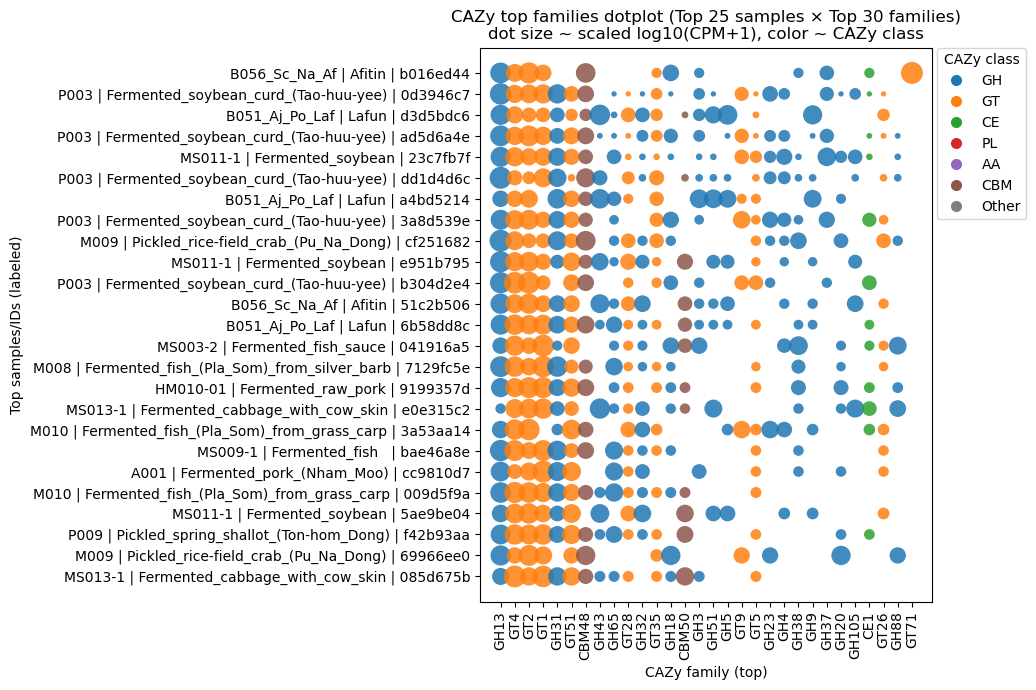

Saved: figures/cazy_topfamilies_dotplot_rel_discrete_labeled.png


In [21]:
# ---------------------------
# Bubble plot: Top CAZy families (x) vs samples (y); size ~ relative abundance, color ~ CAZy class
# ---------------------------
fig_w = max(10, N_FAMS * 0.35)
fig_h = max(6, N_SAMPLES * 0.28)
plt.figure(figsize=(fig_w, fig_h))

plt.scatter(
    long["x"], long["y"],
    s=long["size"].values,
    c=point_colors,
    alpha=0.85,
    edgecolors="none"
)

plt.xticks(range(len(fam_order)), fam_order, rotation=90)

# Y-axis label: use sample | food | short-id (more readable)
y_labels = [make_id_label(u, short_uuid=True) for u in id_order]
plt.yticks(range(len(id_order)), y_labels)

plt.gca().invert_yaxis()
plt.xlabel("CAZy family (top)")
plt.ylabel("Top samples/IDs (labeled)")
plt.title(
    f"CAZy top families dotplot (Top {N_SAMPLES} samples × Top {N_FAMS} families)\n"
    f"dot size ~ scaled log10(CPM+1), color ~ CAZy class"
)

# legend for classes
handles = [
    Line2D([0], [0], marker="o", linestyle="", label=cls,
           markerfacecolor=class_colors[cls], markeredgecolor="none", markersize=8)
    for cls in ["GH","GT","CE","PL","AA","CBM","Other"]
]
plt.legend(handles=handles, title="CAZy class", bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.)

plt.tight_layout()
plt.savefig(OUT, dpi=300)
plt.show()
print("Saved:", OUT)


### Step 6. COG functional composition

**Figures: COG category composition (stacked bars) + PCA (optional).**

- **Stacked bar chart (Top N samples):**  
  - **What it is:** Each bar is one sample; segments are COG categories.  
  - **What it shows:** Relative functional allocation across categories, making it easy to compare category shifts between samples/foods.
- **PCA plot (all samples):**  
  - **What it is:** PCA on the per-sample COG-category profile (after normalization).  
  - **What it shows:** Whether samples cluster by food/category based on higher-level functional composition.


In [22]:
from pathlib import Path
import subprocess, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

%matplotlib inline

# =========================
# Require mapping fns
# =========================
if "id_to_sample" not in globals() or "id_to_food" not in globals():
    raise RuntimeError("Please run the mags_table mapping cell first (id_to_sample/id_to_food).")

# =========================
# Paths / params
# =========================
DATA_DIR = Path("data/07_Functional_analysis/data")
COG_QZA = DATA_DIR / "cog_annot_ft_bacteria_95.qza"

OUT_DIR = Path("figures"); OUT_DIR.mkdir(parents=True, exist_ok=True)
EXPORT_DIR = Path("exported/cog_ft")
TSV = EXPORT_DIR / "feature-table.tsv"

N_UUID = 25  # top samples in stacked bar

# euk UUIDs to exclude
EXCLUDE_UUIDS = {
    "09ebb84d-e6d1-4c36-871b-45bee0ad115d",
    "0c0b33fc-4ed2-4d06-b60c-4a5855e0e58b",
}

UUID_RE = re.compile(r"[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}", re.I)

# use existing canon_id if present; otherwise define
if "canon_id" not in globals():
    def canon_id(s: str) -> str:
        s = str(s).strip()
        m = UUID_RE.search(s)
        if m:
            return m.group(0).lower()
        s = re.sub(r"^MAG[_\-]?", "", s, flags=re.I)
        return s.lower()

EXCLUDE_KEYS = {canon_id(x) for x in EXCLUDE_UUIDS}



In [23]:
# =========================
# Export qza -> tsv (only if needed)
# =========================
if not TSV.exists():
    if EXPORT_DIR.exists():
        shutil.rmtree(EXPORT_DIR)
    EXPORT_DIR.mkdir(parents=True, exist_ok=True)

    subprocess.run(
        ["qiime", "tools", "export", "--input-path", str(COG_QZA), "--output-path", str(EXPORT_DIR)],
        check=True
    )
    subprocess.run(
        ["biom", "convert", "-i", str(EXPORT_DIR / "feature-table.biom"), "-o", str(TSV), "--to-tsv"],
        check=True
    )



In [24]:
# =========================
# Helpers
# =========================
def read_biom_tsv(tsv_path: Path) -> pd.DataFrame:
    """
    biom convert output:
      line1: # Constructed from biom file
      line2: #OTU ID <sample1> <sample2> ...
    So: skip row 1 and use row 2 as the header
    """
    df = pd.read_csv(tsv_path, sep="\t", skiprows=1)
    df = df.set_index(df.columns[0])
    df = df.apply(pd.to_numeric, errors="coerce").fillna(0)
    return df  # features x sampleIDs

def pca_2d(X: np.ndarray):
    Xc = X - X.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    scores = U[:, :2] * S[:2]
    var = (S**2) / (X.shape[0] - 1)
    evr = var / var.sum()
    return scores, evr[:2]

def drop_excluded_columns(mat_fxS: pd.DataFrame) -> pd.DataFrame:
    """Drop excluded UUID cols; if member_to_rep exists, also drop corresponding reps."""
    cols = list(mat_fxS.columns)
    to_drop = set(c for c in cols if c in EXCLUDE_KEYS)

    if "member_to_rep" in globals():
        for u in EXCLUDE_KEYS:
            rep = member_to_rep.get(u)
            if rep is not None and rep in cols:
                to_drop.add(rep)

    if to_drop:
        print("Excluding columns:", sorted(to_drop))
        return mat_fxS.drop(columns=list(to_drop), errors="ignore")
    return mat_fxS

def make_label(sid: str) -> str:
    """
    sid can be UUID or rep id. Label as:
      sample_ID | food | short
    """
    sid = str(sid)
    sample = id_to_sample(sid)
    food = id_to_food(sid)
    if UUID_RE.search(sid):
        short = canon_id(sid)[:8]
    else:
        short = sid
    return f"{sample} | {food} | {short}"

def pca_plot(mat_features_x_samples: pd.DataFrame,
             title: str,
             outpath: Path,
             color_by: str = "food",
             zoom_quantile: tuple[float, float] | None = None,
             outlier_report_path: Path | None = None,
             legend_max_groups: int = 15):

    X = mat_features_x_samples.T.copy()  # samples x features
    X = np.log1p(X)
    X = (X - X.mean(axis=0)) / X.std(axis=0).replace(0, 1)

    scores, evr2 = pca_2d(X.values)
    pc1, pc2 = scores[:, 0], scores[:, 1]

    if color_by == "food":
        groups = pd.Series([id_to_food(i) for i in X.index], index=X.index)
        group_name = "Food"
    elif color_by == "sample":
        groups = pd.Series([id_to_sample(i) for i in X.index], index=X.index)
        group_name = "Sample"
    else:
        groups = pd.Series(["All"] * len(X.index), index=X.index)
        group_name = "Group"

    xlim = ylim = None
    outlier_mask = np.zeros(len(X.index), dtype=bool)
    if zoom_quantile is not None:
        lo, hi = zoom_quantile
        x1, x2 = np.quantile(pc1, [lo, hi])
        y1, y2 = np.quantile(pc2, [lo, hi])
        xpad = 0.05 * (x2 - x1 if x2 > x1 else 1)
        ypad = 0.05 * (y2 - y1 if y2 > y1 else 1)
        xlim = (x1 - xpad, x2 + xpad)
        ylim = (y1 - ypad, y2 + ypad)
        outlier_mask = (pc1 < xlim[0]) | (pc1 > xlim[1]) | (pc2 < ylim[0]) | (pc2 > ylim[1])

        if outlier_report_path is not None:
            out_df = pd.DataFrame({
                "id": list(X.index),
                "sample_ID": [id_to_sample(i) for i in X.index],
                "food": [id_to_food(i) for i in X.index],
                "PC1": pc1,
                "PC2": pc2,
                "is_outlier": outlier_mask
            }).sort_values(["is_outlier", "PC1"], ascending=[False, True])
            out_df.to_csv(outlier_report_path, sep="\t", index=False)
            print("Saved outlier report:", outlier_report_path)
            print("Outliers (top 10):")
            print(out_df[out_df["is_outlier"]].head(10).to_string(index=False))

    plt.figure(figsize=(8, 6))
    uniq = groups.unique().tolist()
    show_legend = len(uniq) <= legend_max_groups

    for g in uniq:
        m = (groups == g).values
        plt.scatter(pc1[m], pc2[m], alpha=0.75, s=25, label=g if show_legend else None)

    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel(f"PC1 ({evr2[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({evr2[1]*100:.1f}%)")
    plt.title(title)

    if show_legend:
        plt.legend(title=group_name, bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)

    plt.tight_layout()
    plt.savefig(outpath, dpi=300)
    plt.show()
    print("Saved:", outpath)



In [25]:
# =========================
# Load + normalize + exclude
# =========================
cog_mat = read_biom_tsv(TSV)

# normalize column IDs + merge duplicates
cog_mat.columns = [canon_id(c) if UUID_RE.search(str(c)) else str(c).strip() for c in cog_mat.columns]
cog_mat = cog_mat.T.groupby(level=0).sum().T

# exclude euks
cog_mat = drop_excluded_columns(cog_mat)

print("COG matrix shape (features x sampleIDs):", cog_mat.shape)
print("Example features:", list(cog_mat.index[:10]))
print("Example sampleIDs:", list(cog_mat.columns[:5]))

feat = cog_mat.index.astype(str)
is_letter_cat = feat.map(lambda x: len(x) == 1 and x.isalpha()).all()



Excluding columns: ['09ebb84d-e6d1-4c36-871b-45bee0ad115d']
COG matrix shape (features x sampleIDs): (24, 169)
Example features: ['S', 'J', 'E', 'G', 'L', 'K', 'P', 'M', 'F', 'C']
Example sampleIDs: ['009d5f9a-be92-4328-b5ad-68d282a94e3b', '0174159a-d8ba-4d10-995d-c9dddd2a0b48', '01b54364-1bbb-43e7-9366-a931641ff6cd', '033e4bc6-2e06-4d36-a408-30aae536885c', '03727db6-e5bc-48a7-8dd0-01ef817cde25']


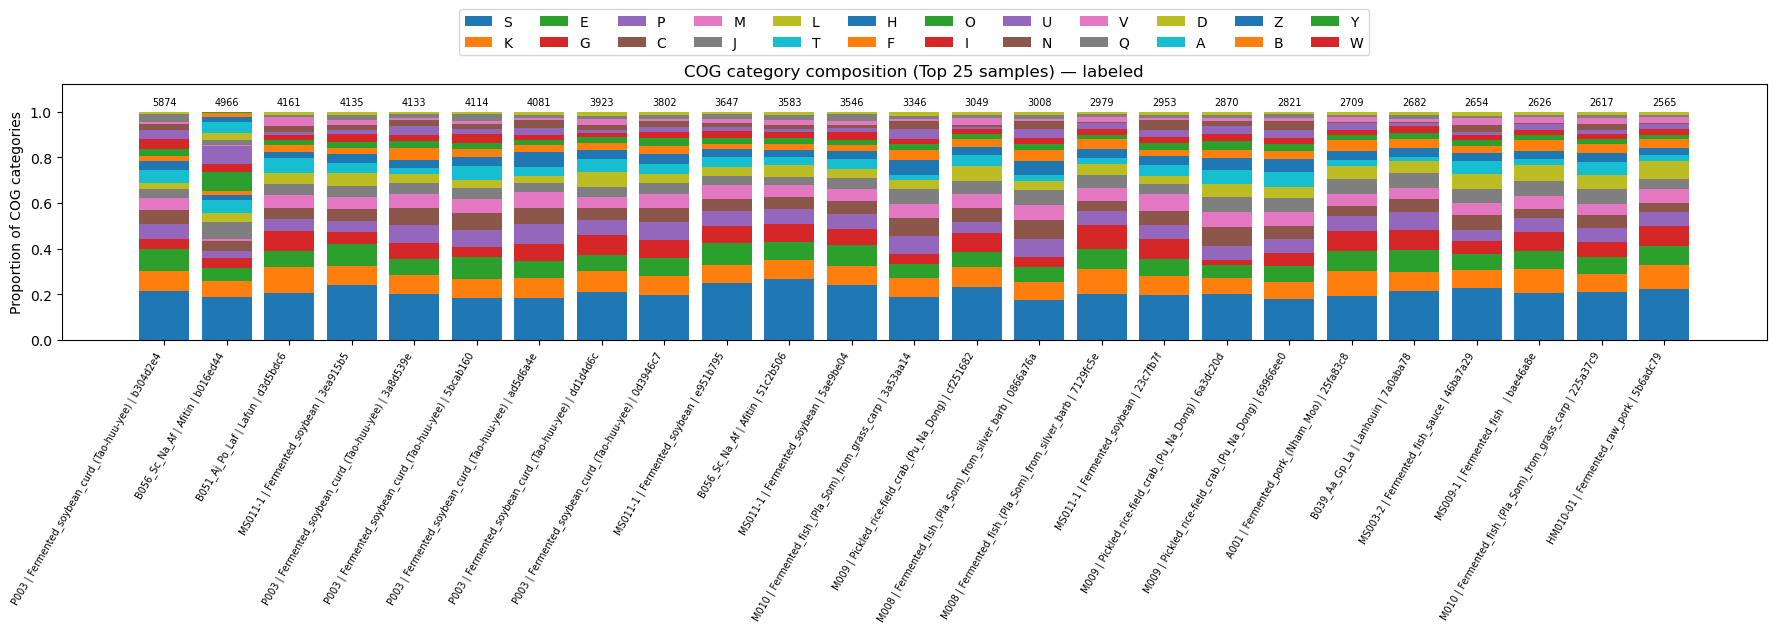

Saved: figures/cog_category_stackedbar_top_labeled.png


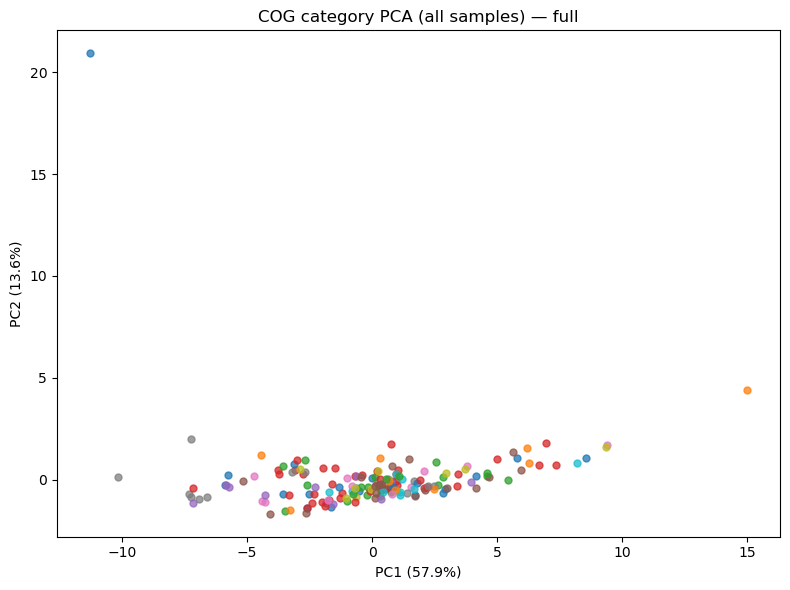

Saved: figures/cog_category_pca_all_full.png
Saved outlier report: figures/cog_category_pca_all_outliers.tsv
Outliers (top 10):
                                  id     sample_ID                                              food        PC1       PC2  is_outlier
b016ed44-d4d7-4927-b6fc-b8eb341adbf7 B056_Sc_Na_Af                                            Afitin -11.284875 20.921283        True
b304d2e4-3e55-47a1-87e1-f2582bedd2a5          P003              Fermented_soybean_curd_(Tao-huu-yee) -10.172107  0.137998        True
62c0d33d-a889-472c-8f54-a2096be506e7          M002 Pickled_mussel_(Hoy_Dong)_from_Asian_green_mussel  14.990020  4.410387        True


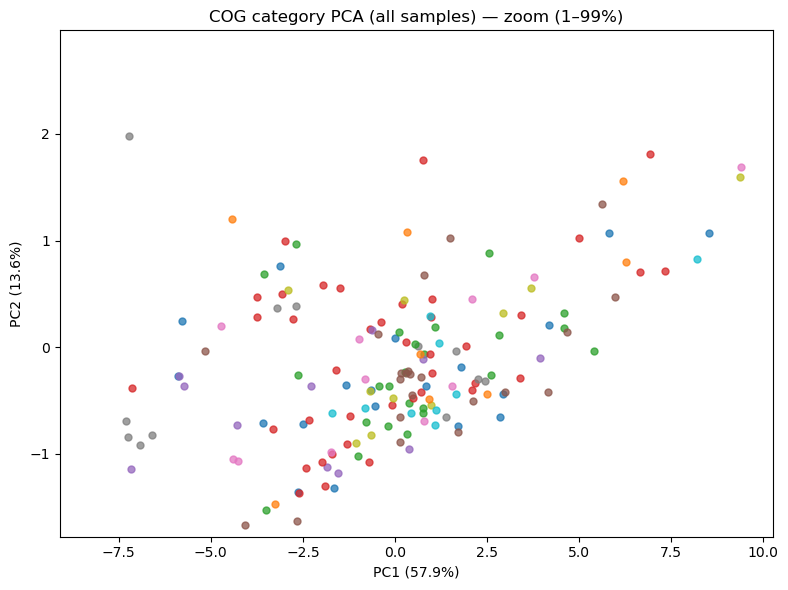

Saved: figures/cog_category_pca_all_zoom.png


In [26]:
# =========================
# CASE A: single-letter categories
# =========================
if is_letter_cat:
    cat_sum = cog_mat.groupby(feat).sum()  # category x sampleID
    totals = cat_sum.sum(axis=0)           # total per sampleID

    top_ids = totals.sort_values(ascending=False).head(N_UUID).index

    prop = (cat_sum[top_ids] / totals.loc[top_ids].replace(0, np.nan)).T.fillna(0)  # sampleID x category
    cat_order = prop.sum(axis=0).sort_values(ascending=False).index
    prop = prop[cat_order]

    # ---- stacked bar (mapped labels) ----
    fig, ax = plt.subplots(figsize=(22, 8))
    x = np.arange(prop.shape[0])
    bottom = np.zeros(prop.shape[0])

    for c in prop.columns:
        vals = prop[c].values
        ax.bar(x, vals, bottom=bottom, label=c)
        bottom += vals

    ax.set_ylim(0, 1.12)
    for i, sid in enumerate(prop.index):
        ax.text(i, 1.02, f"{int(totals.loc[sid])}", ha="center", va="bottom", fontsize=7, clip_on=True)

    ax.set_xticks(x)
    ax.set_xticklabels([make_label(sid) for sid in prop.index], rotation=60, ha="right", fontsize=7)
    ax.set_ylabel("Proportion of COG categories")
    ax.set_title(f"COG category composition (Top {N_UUID} samples) — labeled")

    fig.subplots_adjust(bottom=0.40, top=0.72)
    ax.legend(ncols=12, bbox_to_anchor=(0.5, 1.32), loc="upper center")

    out1 = OUT_DIR / "cog_category_stackedbar_top_labeled.png"
    fig.savefig(out1, dpi=300)
    plt.show()
    print("Saved:", out1)

    # ---- PCA on categories (all samples) ----
    out_full = OUT_DIR / "cog_category_pca_all_full.png"
    out_zoom = OUT_DIR / "cog_category_pca_all_zoom.png"
    out_outliers = OUT_DIR / "cog_category_pca_all_outliers.tsv"

    pca_plot(
        cat_sum,  # category x sampleID
        title="COG category PCA (all samples) — full",
        outpath=out_full,
        color_by="food",
        zoom_quantile=None
    )

    pca_plot(
        cat_sum,
        title="COG category PCA (all samples) — zoom (1–99%)",
        outpath=out_zoom,
        color_by="food",
        zoom_quantile=(0.01, 0.99),
        outlier_report_path=out_outliers
    )



In [27]:
# =========================
# CASE B: not single-letter categories
# =========================
if not is_letter_cat:
    print("⚠️ Features are not single-letter COG categories (J/K/L...). PCA will be run on the feature dimension (colored by food).")

    out_full = OUT_DIR / "cog_feature_pca_all_full.png"
    out_zoom = OUT_DIR / "cog_feature_pca_all_zoom.png"
    out_outliers = OUT_DIR / "cog_feature_pca_all_outliers.tsv"

    pca_plot(
        cog_mat,  # feature x sampleID
        title="COG feature PCA (all samples) — full",
        outpath=out_full,
        color_by="food",
        zoom_quantile=None
    )

    pca_plot(
        cog_mat,
        title="COG feature PCA (all samples) — zoom (1–99%)",
        outpath=out_zoom,
        color_by="food",
        zoom_quantile=(0.01, 0.99),
        outlier_report_path=out_outliers
    )


### Step 7. AMR total burden by sample

**Figure: bar plot of total AMR signal per sample (Top N).**

- **What it is:** The AMR feature table is summed across features to a single total per sample (merging runs where applicable).
- **What it shows:** Which samples have a relatively higher overall AMR signal. This is a coarse summary (it does not tell you *which* genes drive the signal).
- **Outputs:** A figure file plus a TSV table of the top samples are saved to `figures/`.


In [28]:
from pathlib import Path
import subprocess, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# AMR total burden by SAMPLE (merge runs)
# Input: FeatureTable[Frequency] amr_ft_bacteria_95.qza
# Output:
#   figures/amr_total_counts_topSamples.png
#   figures/amr_total_topSamples.tsv
# =========================

# -------------------
# paths / params
# -------------------
DATA_DIR = Path("data/07_Functional_analysis/data")
AMR_FT_QZA = DATA_DIR / "amr_ft_bacteria_95.qza"

# Metadata (for mapping sample -> food/category)
META_CANDIDATES = [
    Path("merged_metadata_filtered.tsv"),
    Path("data/merged_metadata_filtered.tsv"),
]
META_TSV = next((p for p in META_CANDIDATES if p.exists()), None)

OUT_DIR = Path("figures"); OUT_DIR.mkdir(parents=True, exist_ok=True)
EXP_FT  = Path("exported/amr_ft")
FT_TSV  = EXP_FT / "feature-table.tsv"

N_SAMPLES = 25
DO_EXPORT = True  # If TSV is already generated and up-to-date, switch this to False

# -------------------
# helpers
# -------------------
def read_biom_tsv(tsv_path: Path) -> pd.DataFrame:
    # biom convert output: row 1 is a comment, row 2 is the header (#OTU ID + sample IDs)
    df = pd.read_csv(tsv_path, sep="\t", skiprows=1)
    df = df.set_index(df.columns[0])
    df = df.apply(pd.to_numeric, errors="coerce").fillna(0)
    return df  # features x columns(run IDs)

def extract_sample(col: str) -> str:
    """
    Column example:
      PB_MS001-3/01486816-...
      IL_A001/71779113-...
    Return sample name without platform prefix and without /uuid:
      MS001-3, A001, ...
    """
    left = str(col).split("/", 1)[0]
    left = left.replace("PB_", "", 1).replace("IL_", "", 1)
    return left

def load_metadata(meta_path: Path | None) -> pd.DataFrame | None:
    if meta_path is None:
        print("Warning: merged_metadata_filtered.tsv not found. Will plot without food/category labels.")
        return None
    meta = pd.read_csv(meta_path, sep="\t", dtype=str)
    # Standardize the sample_ID column name
    if "sample_ID" not in meta.columns:
        # Fallback: look for similar column names
        for c in meta.columns:
            if c.lower() in ["sample-id", "sampleid", "#sampleid", "sample_id"]:
                meta = meta.rename(columns={c: "sample_ID"})
                break
    if "sample_ID" not in meta.columns:
        print(f"Warning: metadata has no sample_ID column. Columns: {meta.columns.tolist()}")
        return None
    meta["sample_ID"] = meta["sample_ID"].astype(str)
    return meta

def build_sample_meta_maps(meta: pd.DataFrame | None):
    if meta is None:
        return {}, {}
    food_col = "fermented_food_type" if "fermented_food_type" in meta.columns else None
    cat_col  = "category" if "category" in meta.columns else None

    sample2food = {}
    if food_col:
        sample2food = meta.drop_duplicates("sample_ID").set_index("sample_ID")[food_col].to_dict()

    sample2cat = {}
    if cat_col:
        sample2cat = meta.drop_duplicates("sample_ID").set_index("sample_ID")[cat_col].to_dict()

    print("Metadata mapping columns:",
          "food=" + (food_col if food_col else "NA"),
          "category=" + (cat_col if cat_col else "NA"))
    return sample2food, sample2cat

def make_sample_label(sample: str, sample2food: dict) -> str:
    food = sample2food.get(sample, "NA")
    return f"{sample} | {food}" if food != "NA" else sample



In [29]:
# -------------------
# export qza -> tsv (optional)
# -------------------
if DO_EXPORT or (not FT_TSV.exists()):
    if EXP_FT.exists():
        shutil.rmtree(EXP_FT)
    EXP_FT.mkdir(parents=True, exist_ok=True)

    subprocess.run(
        ["qiime", "tools", "export", "--input-path", str(AMR_FT_QZA), "--output-path", str(EXP_FT)],
        check=True
    )
    subprocess.run(
        ["biom", "convert", "-i", str(EXP_FT / "feature-table.biom"), "-o", str(FT_TSV), "--to-tsv"],
        check=True
    )

print("Using TSV:", FT_TSV)



/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported data/07_Functional_analysis/data/amr_ft_bacteria_95.qza as BIOMV210DirFmt to directory exported/amr_ft
Using TSV: exported/amr_ft/feature-table.tsv


In [30]:
# -------------------
# load AMR table
# -------------------
amr_mat = read_biom_tsv(FT_TSV)

# total per run
totals_run = amr_mat.sum(axis=0)  # index = run IDs (columns)

df = pd.DataFrame({
    "run": totals_run.index.astype(str),
    "amr_total": totals_run.values
})
df["sample_ID"] = df["run"].map(extract_sample)

# merge runs -> sample
by_sample = (
    df.groupby("sample_ID", as_index=True)["amr_total"]
      .sum()
      .sort_values(ascending=False)
)



Metadata mapping columns: food=fermented_food_type category=category


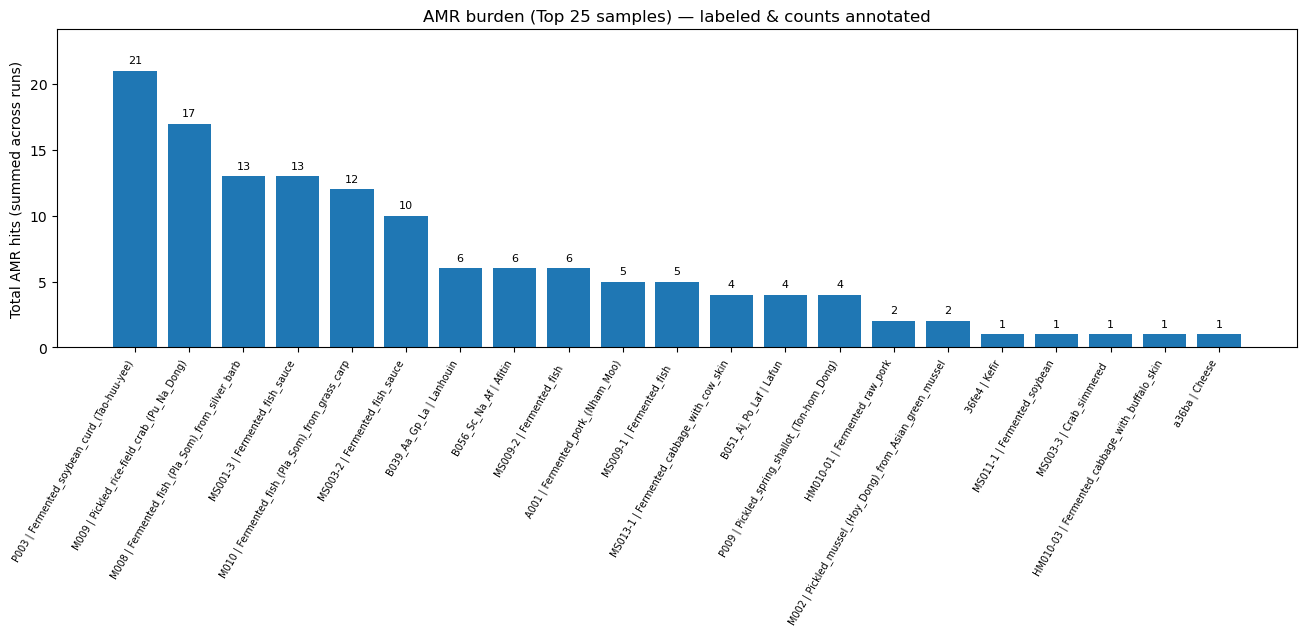

Saved: figures/amr_total_counts_topSamples.png
Saved: figures/amr_total_topSamples.tsv


,sample_ID,amr_total_sum_runs,food,category
0,P003,21.0,Fermented_soybean_curd_(Tao-huu-yee),fermented legumes
1,M009,17.0,Pickled_rice-field_crab_(Pu_Na_Dong),fermented fish
2,M008,13.0,Fermented_fish_(Pla_Som)_from_silver_barb,fermented fish
3,MS001-3,13.0,Fermented_fish_sauce,fermented fish
4,M010,12.0,Fermented_fish_(Pla_Som)_from_grass_carp,fermented fish
5,MS003-2,10.0,Fermented_fish_sauce,fermented fish
6,B039_Aa_Gp_La,6.0,Lanhouin,fermented fish
7,B056_Sc_Na_Af,6.0,Afitin,fermented legumes
8,MS009-2,6.0,Fermented_fish,fermented fish
9,A001,5.0,Fermented_pork_(Nham_Moo),fermented meat


In [31]:
# -------------------
# attach food/category
# -------------------
meta = load_metadata(META_TSV)
sample2food, sample2cat = build_sample_meta_maps(meta)

by_sample_df = by_sample.to_frame("amr_total_sum_runs")
by_sample_df["food"] = [sample2food.get(s, "NA") for s in by_sample_df.index]
by_sample_df["category"] = [sample2cat.get(s, "NA") for s in by_sample_df.index]

# -------------------
# plot Top N samples
# -------------------
top_df = by_sample_df.head(N_SAMPLES).copy()

labels = [make_sample_label(s, sample2food) for s in top_df.index]
values = top_df["amr_total_sum_runs"].values

fig, ax = plt.subplots(figsize=(16, 6))
x = np.arange(len(top_df))
ax.bar(x, values)

ymax = values.max() if values.max() > 0 else 1
ax.set_ylim(0, ymax * 1.15)

for i, v in enumerate(values):
    ax.text(i, v + ymax * 0.02, f"{int(v)}", ha="center", va="bottom", fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=60, ha="right", fontsize=7)
ax.set_ylabel("Total AMR hits (summed across runs)")
ax.set_title(f"AMR burden (Top {N_SAMPLES} samples) — labeled & counts annotated")
fig.subplots_adjust(bottom=0.35)

out_fig = OUT_DIR / "amr_total_counts_topSamples.png"
fig.savefig(out_fig, dpi=300)
plt.show()
print("Saved:", out_fig)

# -------------------
# save table
# -------------------
out_tsv = OUT_DIR / "amr_total_topSamples.tsv"
top_df.reset_index().rename(columns={"index": "sample_ID"}).to_csv(out_tsv, sep="\t", index=False)
print("Saved:", out_tsv)

display(top_df.reset_index())


### Step 8. AMR additional summaries

**Figures: grouped distribution plots of AMR totals (boxplot + points), optionally on a log scale.**

- **What it is:** AMR totals are compared across metadata groups (e.g., fermented food type).  
  The **box** summarizes median + IQR, and the overlaid **points** show individual samples.
- **What it shows:** Differences in the distribution of AMR totals between groups, plus within-group variability and outliers (visible as points).
- **Tip:** Use the log-scale version when totals span orders of magnitude, to avoid the plot being dominated by a few large values.


In [32]:
from pathlib import Path
import subprocess, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# =========================
# 0) Config
# =========================
DATA_DIR = Path("data/07_Functional_analysis/data")
AMR_FT_QZA = DATA_DIR / "amr_ft_bacteria_95.qza"

OUT_DIR = Path("figures"); OUT_DIR.mkdir(parents=True, exist_ok=True)
EXP_FT  = Path("exported/amr_ft")
FT_TSV  = EXP_FT / "feature-table.tsv"

# Metadata (auto-detect two common locations)
META_CANDIDATES = [Path("merged_metadata_filtered.tsv"), Path("data/merged_metadata_filtered.tsv")]
META_TSV = next((p for p in META_CANDIDATES if p.exists()), None)

DO_EXPORT = True   # If TSV is already exported and up-to-date, you can set this to False
TOP_N = 25         # Top samples barplot



In [33]:
# =========================
# 1) Helpers
# =========================
def read_biom_tsv(tsv_path: Path) -> pd.DataFrame:
    """biom convert output: row 1 is a comment, row 2 is the header (#OTU ID + sample IDs)."""
    df = pd.read_csv(tsv_path, sep="\t", skiprows=1)
    df = df.set_index(df.columns[0])
    df = df.apply(pd.to_numeric, errors="coerce").fillna(0)
    return df  # features x columns(run IDs)

def extract_sample(col: str) -> str:
    """
    Column example:
      PB_MS001-3/01486816-...
      IL_A001/71779113-...
    Return sample_ID (strip platform prefix + strip /uuid):
      MS001-3, A001, ...
    """
    left = str(col).split("/", 1)[0]
    left = left.replace("PB_", "", 1).replace("IL_", "", 1)
    return left

def extract_platform(col: str) -> str:
    left = str(col).split("/", 1)[0]
    if left.startswith("PB_"):
        return "PB"
    if left.startswith("IL_"):
        return "IL"
    return "NA"

def load_metadata(meta_path: Path | None) -> pd.DataFrame | None:
    if meta_path is None:
        print("❗ Warning: merged_metadata_filtered.tsv not found. Will plot without food/category.")
        return None
    meta = pd.read_csv(meta_path, sep="\t", dtype=str)

    # normalize sample_ID col
    if "sample_ID" not in meta.columns:
        for c in meta.columns:
            if c.lower() in ["sample-id", "sampleid", "#sampleid", "sample_id"]:
                meta = meta.rename(columns={c: "sample_ID"})
                break
    if "sample_ID" not in meta.columns:
        print("❗ Warning: metadata has no sample_ID column. Columns:", meta.columns.tolist())
        return None

    meta["sample_ID"] = meta["sample_ID"].astype(str)
    return meta

def annotate_bars(ax, values, pad_frac=0.03, fontsize=8, fmt=None):
    """
    values: array-like
    fmt: None -> int; or callable(v)->str
    """
    values = np.asarray(values, dtype=float)
    vmax = float(np.nanmax(values)) if len(values) else 0.0
    if not np.isfinite(vmax) or vmax <= 0:
        vmax = 1.0

    # Increase the y-axis upper limit to leave room for labels
    ax.set_ylim(0, vmax * 1.30)

    if fmt is None:
        fmt = lambda v: f"{int(round(v))}"

    for i, v in enumerate(values):
        ax.text(
            i, v + vmax * pad_frac,
            fmt(v),
            ha="center", va="bottom",
            fontsize=fontsize,
            clip_on=True
        )

def make_label(sample_id: str, food: str | float) -> str:
    if pd.notna(food):
        return f"{sample_id} | {food}"
    return str(sample_id)



In [34]:
# =========================
# 2) Export qza -> tsv (only if needed)
# =========================
if DO_EXPORT or (not FT_TSV.exists()):
    if EXP_FT.exists():
        shutil.rmtree(EXP_FT)
    EXP_FT.mkdir(parents=True, exist_ok=True)

    subprocess.run(
        ["qiime", "tools", "export", "--input-path", str(AMR_FT_QZA), "--output-path", str(EXP_FT)],
        check=True
    )
    subprocess.run(
        ["biom", "convert", "-i", str(EXP_FT / "feature-table.biom"), "-o", str(FT_TSV), "--to-tsv"],
        check=True
    )

print("Using AMR TSV:", FT_TSV)



/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported data/07_Functional_analysis/data/amr_ft_bacteria_95.qza as BIOMV210DirFmt to directory exported/amr_ft
Using AMR TSV: exported/amr_ft/feature-table.tsv


In [35]:
# =========================
# 3) Build per-sample AMR totals (merge PB/IL runs)
# =========================
amr_mat = read_biom_tsv(FT_TSV)

# total per run/column
totals_run = amr_mat.sum(axis=0)  # index=run columns

runs = pd.DataFrame({
    "run_col": totals_run.index.astype(str),
    "platform": [extract_platform(c) for c in totals_run.index.astype(str)],
    "sample_ID": [extract_sample(c) for c in totals_run.index.astype(str)],
    "amr_total_run": totals_run.values
})

# merge runs -> sample
sample_totals = runs.groupby("sample_ID")["amr_total_run"].sum().sort_values(ascending=False)
sample_nruns  = runs.groupby("sample_ID")["run_col"].nunique()

sample_df = pd.DataFrame({
    "amr_total_sum_runs": sample_totals,
    "n_runs": sample_nruns.reindex(sample_totals.index).fillna(0).astype(int)
})



In [36]:
# =========================
# 4) Attach metadata (food/category)
# =========================
meta = load_metadata(META_TSV)
if meta is not None:
    FOOD_COL = "fermented_food_type" if "fermented_food_type" in meta.columns else None
    CAT_COL  = "category" if "category" in meta.columns else None

    meta1 = meta.drop_duplicates("sample_ID").set_index("sample_ID")

    if FOOD_COL:
        sample_df["fermented_food_type"] = sample_df.index.map(meta1[FOOD_COL])
    else:
        sample_df["fermented_food_type"] = np.nan

    if CAT_COL:
        sample_df["category"] = sample_df.index.map(meta1[CAT_COL])
    else:
        sample_df["category"] = np.nan
else:
    sample_df["fermented_food_type"] = np.nan
    sample_df["category"] = np.nan

display(sample_df.head())



,amr_total_sum_runs,n_runs,fermented_food_type,category
sample_ID,,,,
P003,21.0,8,Fermented_soybean_curd_(Tao-huu-yee),fermented legumes
M009,17.0,7,Pickled_rice-field_crab_(Pu_Na_Dong),fermented fish
M008,13.0,6,Fermented_fish_(Pla_Som)_from_silver_barb,fermented fish
MS001-3,13.0,8,Fermented_fish_sauce,fermented fish
M010,12.0,6,Fermented_fish_(Pla_Som)_from_grass_carp,fermented fish


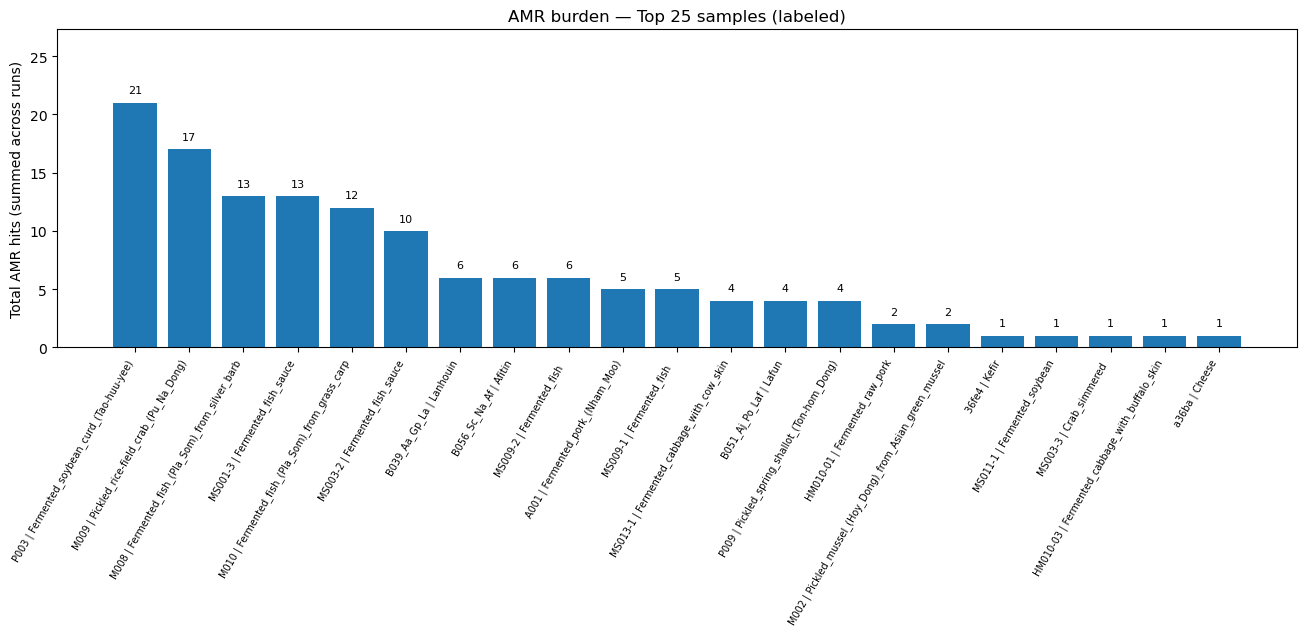

Saved: figures/amr_total_topSamples_bar_labeled.png
Saved: figures/amr_total_topSamples_table.tsv


In [37]:
# =========================
# 5) Plot A: Top N samples barplot# =========================
top = sample_df.head(TOP_N).copy()

labels = [make_label(s, top.loc[s, "fermented_food_type"]) for s in top.index]
vals = top["amr_total_sum_runs"].values

fig, ax = plt.subplots(figsize=(16, 6))
x = np.arange(len(top))
ax.bar(x, vals)

# ✅ Fix: the label for the tallest bar was clipped
annotate_bars(ax, vals, pad_frac=0.03, fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=60, ha="right", fontsize=7)
ax.set_ylabel("Total AMR hits (summed across runs)")
ax.set_title(f"AMR burden — Top {TOP_N} samples (labeled)")
fig.subplots_adjust(bottom=0.35)

out_fig = OUT_DIR / "amr_total_topSamples_bar_labeled.png"
fig.savefig(out_fig, dpi=300)
plt.show()
print("Saved:", out_fig)

out_tsv = OUT_DIR / "amr_total_topSamples_table.tsv"
top.reset_index().rename(columns={"index":"sample_ID"}).to_csv(out_tsv, sep="\t", index=False)
print("Saved:", out_tsv)



In [38]:
# =========================
# 6) Grouped plots: boxplot + jittered points (+ log version)
# =========================
def box_with_points(df: pd.DataFrame,
                    group_col: str,
                    value_col: str = "amr_total_sum_runs",
                    min_n: int = 2,               # groups with n < min_n are merged into "Other"
                    order_by: str = "median",     # median/mean
                    use_log: bool = False,
                    prefix: str = "amr"):
    if group_col not in df.columns:
        print(f"Skip {group_col}: column not in sample_df")
        return

    d = df.dropna(subset=[group_col, value_col]).copy()
    if d.empty:
        print(f"Skip {group_col}: no non-NA values")
        return

    # Merge small groups
    counts = d[group_col].value_counts()
    small = counts[counts < min_n].index
    if len(small) > 0:
        d[group_col] = d[group_col].where(~d[group_col].isin(small), other=f"Other (n<{min_n})")

    # Sort
    if order_by == "mean":
        stat = d.groupby(group_col)[value_col].mean()
    else:
        stat = d.groupby(group_col)[value_col].median()
    order = stat.sort_values(ascending=False).index.tolist()

    data = [d.loc[d[group_col] == g, value_col].values for g in order]
    ns = [len(v) for v in data]

    fig_w = max(10, 0.6 * len(order))
    fig, ax = plt.subplots(figsize=(fig_w, 5.5))

    # boxplot
    ax.boxplot(
        data,
        labels=[f"{g} (n={n})" for g, n in zip(order, ns)],
        showfliers=False
    )

    # Jittered points (n=1 is still visible)
    rng = np.random.default_rng(0)
    for i, vals_i in enumerate(data, start=1):
        jitter = rng.uniform(-0.18, 0.18, size=len(vals_i))
        ax.scatter(np.full(len(vals_i), i) + jitter, vals_i, alpha=0.75, s=22)

    ax.set_ylabel("Total AMR hits per sample (sum runs)")
    ax.set_title(f"AMR burden by {group_col} (box + points){' [log10]' if use_log else ''}")
    ax.tick_params(axis="x", rotation=45)
    for t in ax.get_xticklabels():
        t.set_ha("right")

    if use_log:
        # If there are zeros, log-scale breaks; for display replace <= 0 with 0.5
        ymin = np.min(np.concatenate(data)) if len(data) else 1
        if ymin <= 0:
            print("Warning: non-positive values detected; using log scale after replacing <=0 with 0.5 for display.")
            ax.set_yscale("log")
        else:
            ax.set_yscale("log")

    fig.tight_layout()

    suffix = "log" if use_log else "linear"
    out = OUT_DIR / f"{prefix}_{group_col}_box_points_{suffix}.png"
    fig.savefig(out, dpi=300)
    plt.show()
    print("Saved:", out)

def bar_by_group(df: pd.DataFrame,
                 group_col: str,
                 stat: str = "median",          # sum/mean/median
                 value_col: str = "amr_total_sum_runs",
                 min_n: int = 2,
                 prefix: str = "amr"):
    if group_col not in df.columns:
        print(f"Skip {group_col}: column not in df")
        return

    d = df.dropna(subset=[group_col, value_col]).copy()
    if d.empty:
        print(f"Skip {group_col}: no non-NA values")
        return

    # Merge small groups
    counts = d[group_col].value_counts()
    small = counts[counts < min_n].index
    if len(small) > 0:
        d[group_col] = d[group_col].where(~d[group_col].isin(small), other=f"Other (n<{min_n})")

    # Summary statistics
    if stat == "sum":
        s = d.groupby(group_col)[value_col].sum()
        ylab = "Total AMR hits (sum across samples)"
        fmt = lambda v: f"{int(round(v))}"
    elif stat == "mean":
        s = d.groupby(group_col)[value_col].mean()
        ylab = "Mean AMR hits per sample"
        fmt = lambda v: f"{v:.1f}"
    elif stat == "median":
        s = d.groupby(group_col)[value_col].median()
        ylab = "Median AMR hits per sample"
        fmt = lambda v: f"{v:.1f}"
    else:
        raise ValueError("stat must be one of: sum/mean/median")

    # Sorting: using the median is more stable
    order = d.groupby(group_col)[value_col].median().sort_values(ascending=False).index.tolist()
    s = s.reindex(order)

    # Annotate n=
    n_map = d[group_col].value_counts().to_dict()
    xlabels = [f"{g} (n={int(n_map.get(g,0))})" for g in s.index]

    fig_w = max(10, 0.6 * len(s))
    fig, ax = plt.subplots(figsize=(fig_w, 5))
    x = np.arange(len(s))
    ax.bar(x, s.values)

    # ✅ Annotate in the correct format in one pass; no need to clear()
    annotate_bars(ax, s.values, pad_frac=0.03, fontsize=8, fmt=fmt)

    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=45, ha="right")
    ax.set_ylabel(ylab)
    ax.set_title(f"AMR burden by {group_col} ({stat.upper()})")
    fig.tight_layout()

    out = OUT_DIR / f"{prefix}_{group_col}_bar_{stat}.png"
    fig.savefig(out, dpi=300)
    plt.show()
    print("Saved:", out)

    out_tab = OUT_DIR / f"{prefix}_{group_col}_{stat}.tsv"
    pd.DataFrame({group_col: list(s.index), stat: s.values}).to_csv(out_tab, sep="\t", index=False)
    print("Saved:", out_tab)




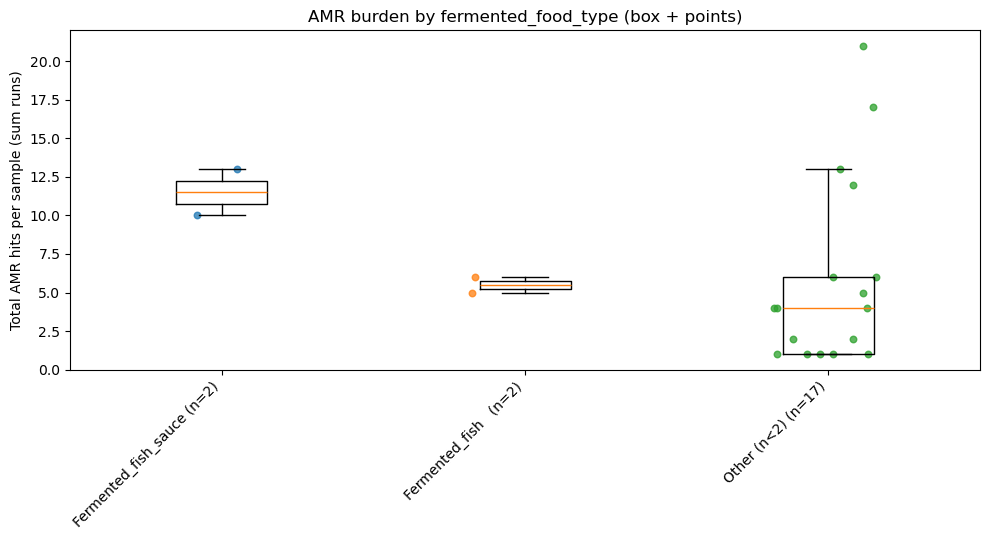

Saved: figures/amr_fermented_food_type_box_points_linear.png


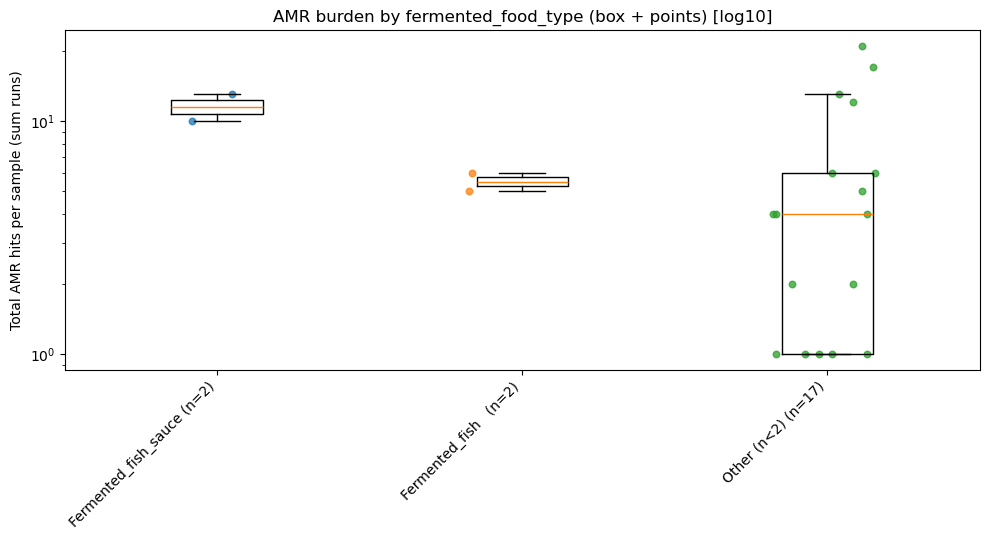

Saved: figures/amr_fermented_food_type_box_points_log.png


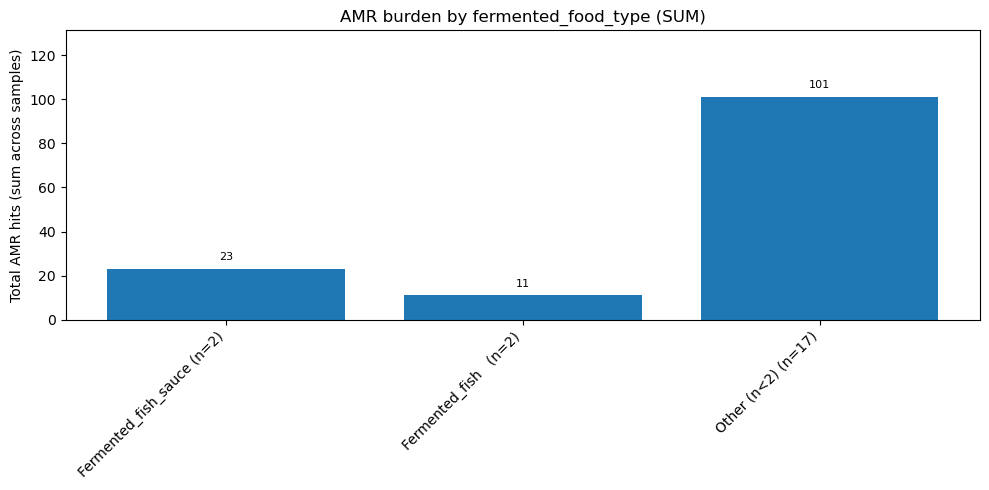

Saved: figures/amr_fermented_food_type_bar_sum.png
Saved: figures/amr_fermented_food_type_sum.tsv


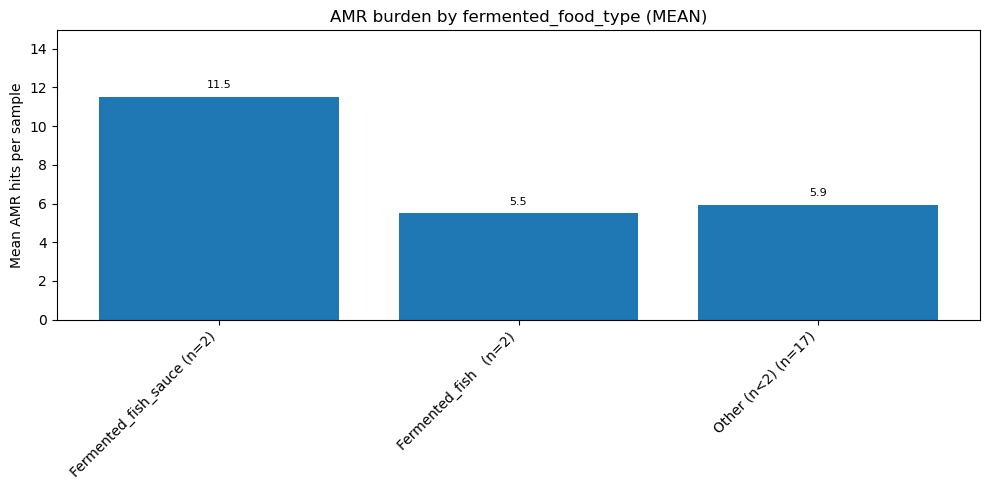

Saved: figures/amr_fermented_food_type_bar_mean.png
Saved: figures/amr_fermented_food_type_mean.tsv


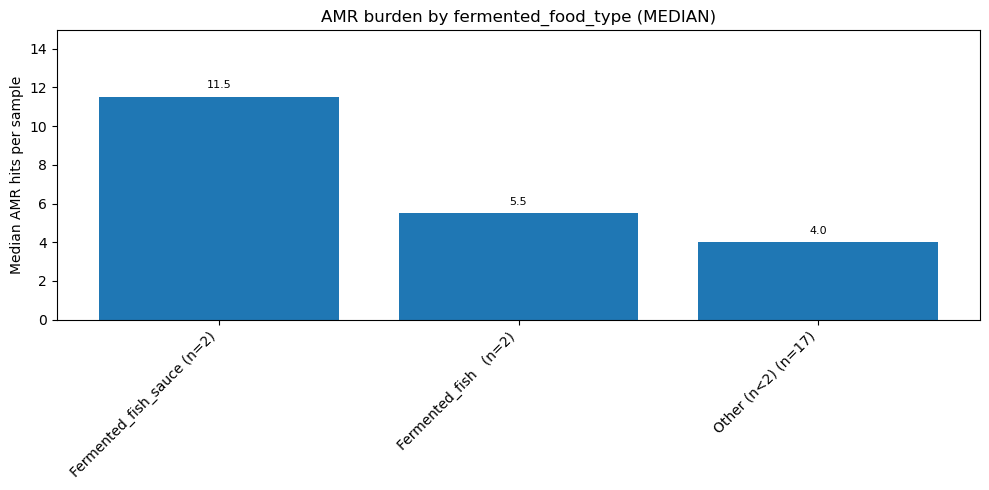

Saved: figures/amr_fermented_food_type_bar_median.png
Saved: figures/amr_fermented_food_type_median.tsv


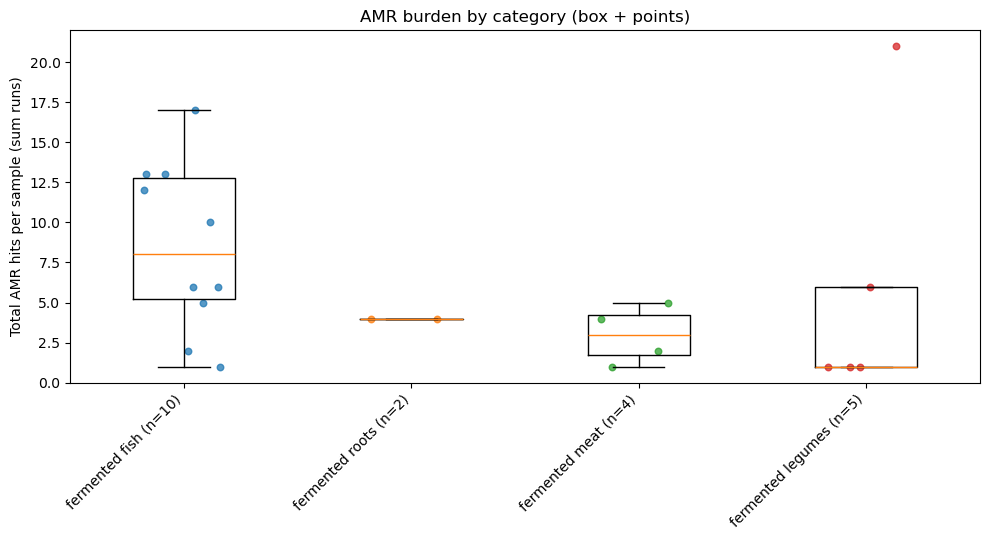

Saved: figures/amr_category_box_points_linear.png


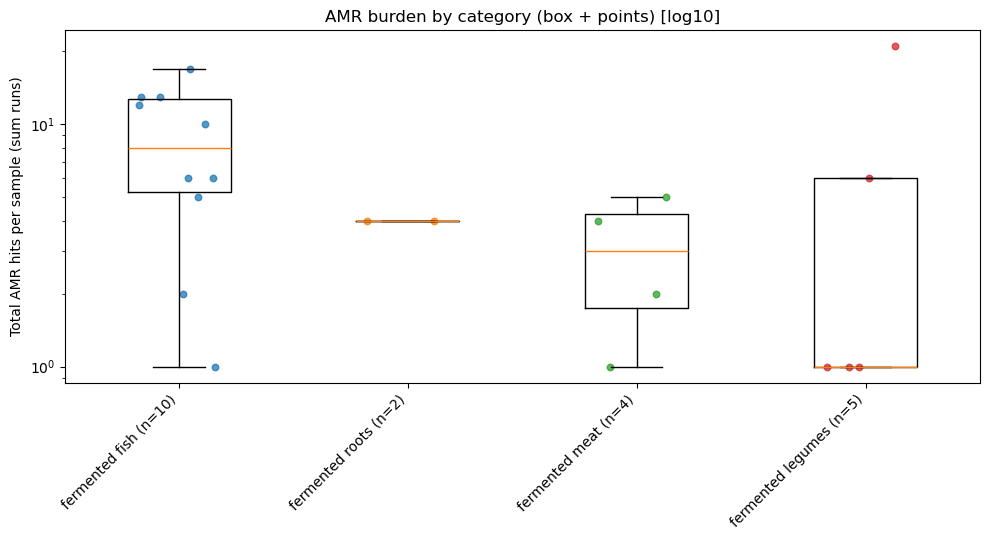

Saved: figures/amr_category_box_points_log.png


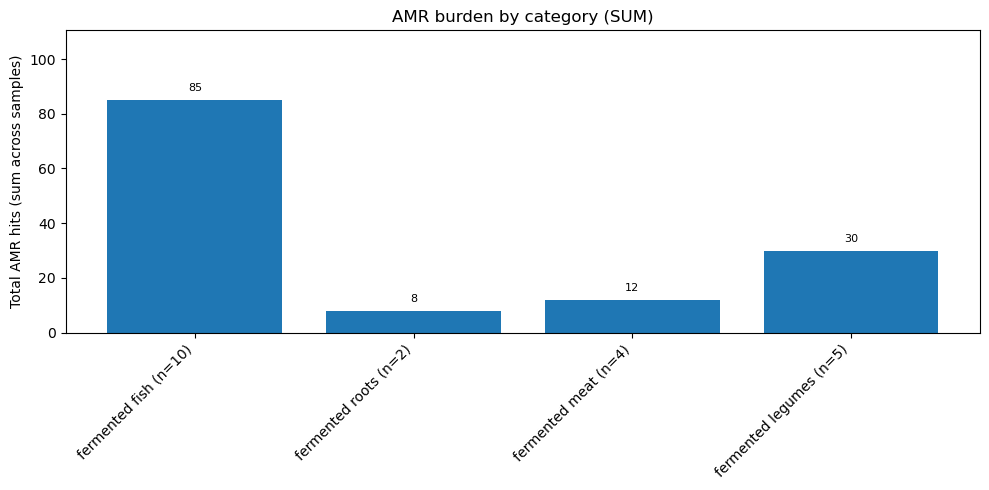

Saved: figures/amr_category_bar_sum.png
Saved: figures/amr_category_sum.tsv


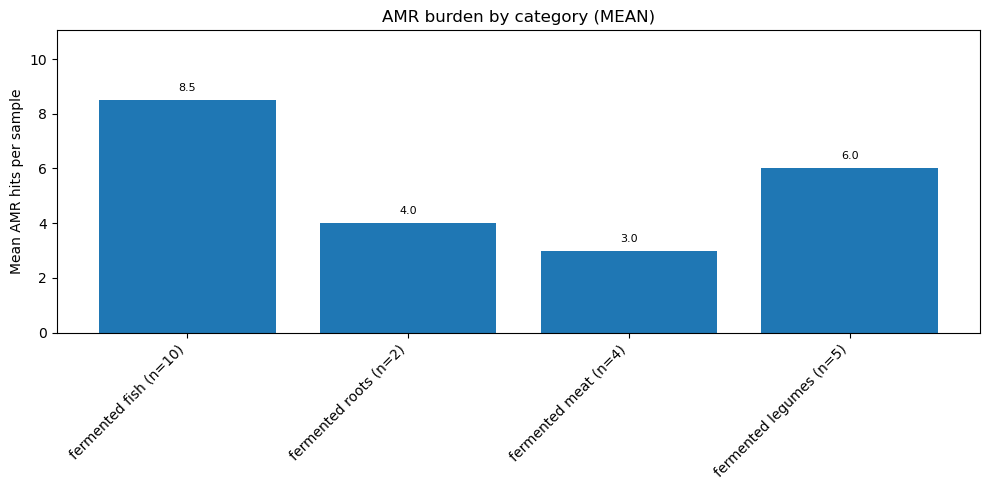

Saved: figures/amr_category_bar_mean.png
Saved: figures/amr_category_mean.tsv


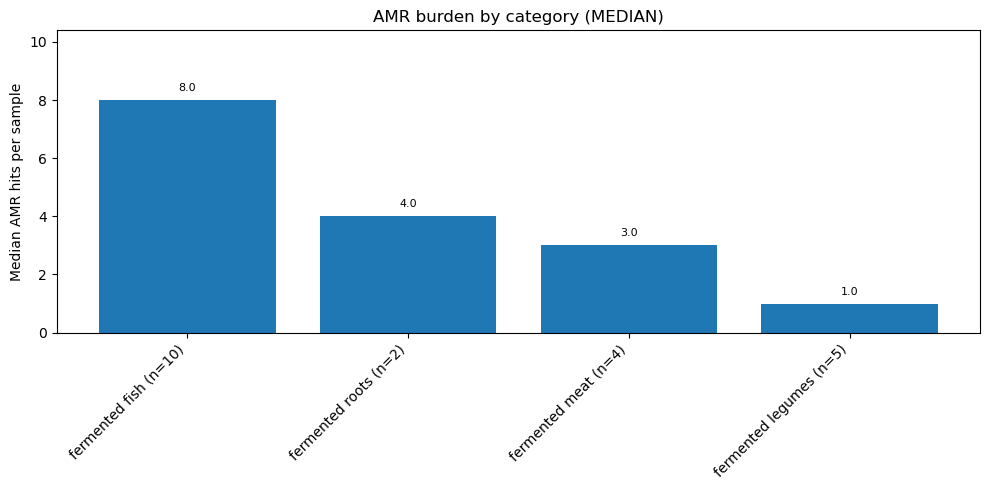

Saved: figures/amr_category_bar_median.png
Saved: figures/amr_category_median.tsv


In [39]:
# ---- fermented_food_type ----
box_with_points(sample_df, "fermented_food_type", min_n=2, use_log=False, prefix="amr")
box_with_points(sample_df, "fermented_food_type", min_n=2, use_log=True,  prefix="amr")

bar_by_group(sample_df, "fermented_food_type", stat="sum",    min_n=2, prefix="amr")
bar_by_group(sample_df, "fermented_food_type", stat="mean",   min_n=2, prefix="amr")
bar_by_group(sample_df, "fermented_food_type", stat="median", min_n=2, prefix="amr")

# ---- category (if exists) ----
if "category" in sample_df.columns:
    box_with_points(sample_df, "category", min_n=2, use_log=False, prefix="amr")
    box_with_points(sample_df, "category", min_n=2, use_log=True,  prefix="amr")

    bar_by_group(sample_df, "category", stat="sum",    min_n=2, prefix="amr")
    bar_by_group(sample_df, "category", stat="mean",   min_n=2, prefix="amr")
    bar_by_group(sample_df, "category", stat="median", min_n=2, prefix="amr")
